# The Impact of Gun Laws on Homicide Rates in the United States
[Gifford's Law Center](https://lawcenter.giffords.org) is a non-profit organizaton whose mission is to reduce gun violence. They provide [annual rankings](https://lawcenter.giffords.org/scorecard/) of state gun laws and measure the rankings against gun homicide rates. A counter-argument made against such results is that, while gun homicide deaths may decrease, the rate of homicides by other means will increase as a result. Here, we will test that theory by first quantifying the results of the Gifford Law Center, then use the grades to see if the results hold true when accounting for homicide rates without guns. If the correlation between strength of gun laws and non-firearm homicide rates is negative, while the correlation with firearm homicide rates is positive, it will lend credence to the arguments made by gun rights activists.

## Scrape Data from Giffords Law Center
The site contains a table of rankings by state, including a gun death rate per 100k people. We will grab 2018 data from this table and parse it into a dataframe. In addition, grades will be translated to a traditional grade points scale so that correlation and p-values can be calculated later.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from bs4 import BeautifulSoup
import requests

# url = 'https://lawcenter.giffords.org/scorecard/#rankings'

# #Make a get request to retrieve the page
# html_page = requests.get(url) 

# #Pass the page contents to beautiful soup for parsing
# soup = BeautifulSoup(html_page.content, 'html.parser') 

# # States use the 'strong' tag
# tables = soup.find_all('table')

In [2]:
# # Create Dictionary for parsing values
# state_rankings_2018 = {'Year': [], 'State':[], 'Grade': [], 'State_GPA': [], 'Gun_Death_Rate': []}

# # Define grading scale
# grades = {'A':4, 'A-': 3.7, 
#           'B+': 3.3, 'B': 3, 'B-':2.7, 
#           'C+': 2.3, 'C': 2, 'C-': 1.7, 
#           'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

# # Iterate through each row of table and save to dictionary
# for i in range(50):
#     state_rankings_2018['Year'].append(2017)
#     state_rankings_2018['State'].append(tables[0].find_all('td')[5 * i + 1].text)
#     state_rankings_2018['Grade'].append(tables[0].find_all('td')[5 * i + 2].text)
#     state_rankings_2018['State_GPA'].append(grades[state_rankings_2018['Grade'][-1]])
#     state_rankings_2018['Gun_Death_Rate'].append(float(tables[0].find_all('td')[5 * i + 4].text))

# # Create dataframe from dictionary
# pd.DataFrame.from_dict(state_rankings_2018).to_csv('national_data/giffords_2018.csv')

# Preview dataframe
giffords_df_2018 = pd.read_csv('national_data/giffords_2018.csv', index_col=0)
giffords_df_2018.head()

,Year,State,Grade,State_GPA,Gun_Death_Rate
0,2017,Alabama,F,0.0,22.9
1,2017,Alaska,F,0.0,24.5
2,2017,Arizona,F,0.0,15.7
3,2017,Arkansas,F,0.0,20.2
4,2017,California,A,4.0,7.8


### Quantify and Visualize Results

R-Square: 0.6207020030717032
Intercept: 17.318130935828243
Slope: -2.9352862159168582
P-Value: 1.129765290532049e-11


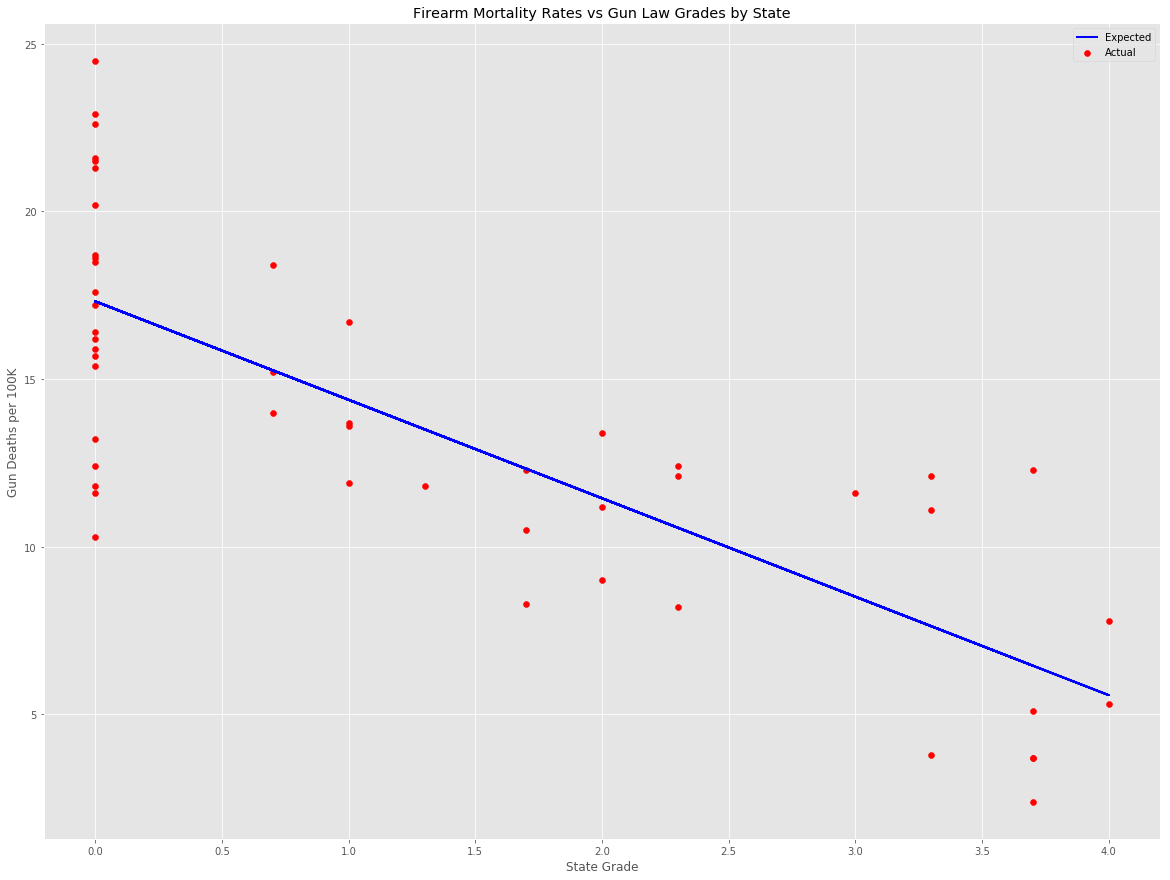

In [3]:
import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.style.use('ggplot')

f = 'Gun_Death_Rate~State_GPA'
model = smf.ols(formula=f, data=giffords_df_2018).fit()

print(f'R-Square: {model.rsquared}') 
print(f'Intercept: {model.params[0]}')
print(f'Slope: {model.params[1]}')
print(f'P-Value: {model.pvalues[1]}')

y_pred = model.predict()
plt.figure(figsize=(20, 15))
plt.title('Firearm Mortality Rates vs Gun Law Grades by State')
plt.xlabel('State Grade')
plt.ylabel('Gun Deaths per 100K')
plt.scatter(giffords_df_2018['State_GPA'], giffords_df_2018['Gun_Death_Rate'], marker='o', label='Actual', color='r')
plt.plot(giffords_df_2018['State_GPA'], y_pred, color='b', lw=2, label='Expected')
plt.legend()
plt.show()

It is clear that a negative correlation exists between the strength of gun laws and the number of gun homicide deaths. However, an R-Square value of 0.62 indicates that the strength of laws only account for 62% of the variation in gun homicide rates. The implication is that the effectiveness of gun laws on gun homicide rates is limited.

## Homicides without Firearms
Age- and population-standardized rates for 2014 - 2017 can be accessed from the CDC's [National Center for Health Statistics](https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm). Similar data can be found for homicide rates with firearms for the same time periods from the [same source](https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm). 

**Standardization Notes:** Homicides occur at greater rates in more population dense regions and among younger generations. If a particular state has an older population and is more rural, it is expected to have lower homicide rates irregardless of the laws in place. By standardizing age and population rates, results can be compared more accurately across time and regions. It is unknown whether or not the Giffords Law Institute has accounted for such variation in their calculated homicide rates with firearms.

In [4]:
homicide_df = pd.read_csv('national_data/Homicide Mortality by State.csv')
homicide_df = homicide_df.rename(columns={'YEAR': 'Year', 
                                          'STATE': 'State', 
                                          'RATE': 'Homicide Rate', 
                                          'DEATHS': 'Homicide Deaths'})
homicide_df=homicide_df.drop('URL', axis=1)
homicide_df.head()

,Year,State,Homicide Rate,Homicide Deaths
0,2017.0,AL,12.9,602
1,2017.0,AK,10.6,78
2,2017.0,AZ,6.6,441
3,2017.0,AR,9.8,278
4,2017.0,CA,5.1,"2,022"


In [5]:
gun_mortality_df = pd.read_csv('national_data/Firearm Mortality by State.csv')
gun_mortality_df = gun_mortality_df.rename(columns={'YEAR': 'Year', 
                                                    'STATE': 'State', 
                                                    'RATE': 'Gun Death Rate', 
                                                    'DEATHS': 'Gun Deaths'})
gun_mortality_df=gun_mortality_df.drop('URL', axis=1)
gun_mortality_df.head()

,Year,State,Gun Death Rate,Gun Deaths
0,2017.0,AL,22.9,"1,124"
1,2017.0,AK,24.5,180
2,2017.0,AZ,15.8,"1,134"
3,2017.0,AR,20.3,613
4,2017.0,CA,7.9,"3,184"


In [6]:
suicides_df = pd.read_csv('national_data/Suicide Mortality by State.csv')
suicides_df = suicides_df.rename(columns={'YEAR': 'Year', 
                                          'STATE': 'State', 
                                          'RATE': 'Suicide Rate', 
                                          'DEATHS': 'Suicide Deaths'})
suicides_df=suicides_df.drop('URL', axis=1)
suicides_df.head()

,Year,State,Suicide Rate,Suicide Deaths
0,2017.0,AL,16.6,836
1,2017.0,AK,27.0,200
2,2017.0,AZ,18.2,"1,327"
3,2017.0,AR,20.8,631
4,2017.0,CA,10.5,"4,312"


In [7]:
accident_df = pd.read_csv('national_data/Accident Mortality by State.csv')
accident_df = accident_df.rename(columns={'YEAR': 'Year', 
                                          'STATE': 'State', 
                                          'RATE': 'Accident Rate', 
                                          'DEATHS': 'Accident Deaths'})
accident_df=accident_df.drop('URL', axis=1)
accident_df.head()

,Year,State,Accident Rate,Accident Deaths
0,2017.0,US,53.8,"2,703"
1,2017.0,AL,53.8,"2,703"
2,2017.0,AK,63.7,436
3,2017.0,AZ,56.2,"4,184"
4,2017.0,AR,51.8,"1,625"


In [8]:
death_rates = gun_mortality_df.join(homicide_df[['Homicide Rate']]).drop('Gun Deaths', axis=1)
death_rates = death_rates.join(suicides_df[['Suicide Rate']])
death_rates = death_rates.join(accident_df[['Accident Rate']])
death_rates = death_rates.dropna()
death_rates.head()

,Year,State,Gun Death Rate,Homicide Rate,Suicide Rate,Accident Rate
0,2017.0,AL,22.9,12.9,16.6,53.8
1,2017.0,AK,24.5,10.6,27.0,53.8
2,2017.0,AZ,15.8,6.6,18.2,63.7
3,2017.0,AR,20.3,9.8,20.8,56.2
4,2017.0,CA,7.9,5.1,10.5,51.8


## Law Grades 2014-2017
The Gifford's Law Center provides historical grades and rankings for prior years as well, and this can be used to compare against CDC data. The 2014 table is laid out slightly differently, so requires a separate pass of the data from other years.

In [9]:
# # Get results for all other years
# state_rankings = {'Year':[], 'State':[], 'Grade':[], 'State_GPA':[]}

# for yr in range(2015, 2018):
#     url = f'https://lawcenter.giffords.org/scorecard{int(yr)}/#rankings'

#     #Make a get request to retrieve the page
#     html_page = requests.get(url) 

#     #Pass the page contents to beautiful soup for parsing
#     soup = BeautifulSoup(html_page.content, 'html.parser') 

#     # States use the 'strong' tag
#     tables = soup.find_all('table')

#     # Define grading scale
#     grades = {'A':4, 'A-': 3.7, 
#               'B+': 3.3, 'B': 3, 'B-':2.7, 
#               'C+': 2.3, 'C': 2, 'C-': 1.7, 
#               'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

#     # Iterate through each row of table and save to dictionary
#     for i in range(50):
#         state_rankings['Year'].append(yr-1)
#         state_rankings['State'].append(tables[0].find_all('td')[5 * i + 1].text.strip())
#         state_rankings['Grade'].append(tables[0].find_all('td')[5 * i + 2].text.strip())
#         state_rankings['State_GPA'].append(grades[state_rankings['Grade'][-1]])

# # Create dataframe from dictionary
# pd.DataFrame.from_dict(state_rankings).to_csv('national_data/giffords.csv')


giffords_df = pd.read_csv('national_data/giffords.csv', index_col=0)
giffords_df = giffords_df.append(giffords_df_2018.drop('Gun_Death_Rate', axis=1))
giffords_df.head()

,Year,State,Grade,State_GPA
0,2014,California,A-,3.7
1,2014,Connecticut,A-,3.7
2,2014,New Jersey,A-,3.7
3,2014,Maryland,A-,3.7
4,2014,Massachusetts,A-,3.7


### State Name/Abbreviation Mapping

In [10]:
state_abbrs = {
            'AK': 'Alaska',
            'AL': 'Alabama',
            'AR': 'Arkansas',
            'AS': 'American Samoa',
            'AZ': 'Arizona',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'GU': 'Guam',
            'HI': 'Hawaii',
            'IA': 'Iowa',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'MA': 'Massachusetts',
            'MD': 'Maryland',
            'ME': 'Maine',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MO': 'Missouri',
            'MP': 'Northern Mariana Islands',
            'MS': 'Mississippi',
            'MT': 'Montana',
            'NA': 'National',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'NE': 'Nebraska',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NV': 'Nevada',
            'NY': 'New York',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'PR': 'Puerto Rico',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VA': 'Virginia',
            'VI': 'Virgin Islands',
            'VT': 'Vermont',
            'WA': 'Washington',
            'WI': 'Wisconsin',
            'WV': 'West Virginia',
            'WY': 'Wyoming'
}

In [11]:
state_names = [state_abbrs[st] for st in list(death_rates['State'])]
death_rates['State Name'] = state_names
death_rates = death_rates.drop('State', axis=1).rename(columns={'State Name': 'State'})
death_rates.head()

,Year,Gun Death Rate,Homicide Rate,Suicide Rate,Accident Rate,State
0,2017.0,22.9,12.9,16.6,53.8,Alabama
1,2017.0,24.5,10.6,27.0,53.8,Alaska
2,2017.0,15.8,6.6,18.2,63.7,Arizona
3,2017.0,20.3,9.8,20.8,56.2,Arkansas
4,2017.0,7.9,5.1,10.5,51.8,California


### Join Data

In [12]:
death_rates['Year'] = death_rates.Year.astype(int)
death_rates = death_rates[death_rates['Year'] >= 2014]
death_rates['Year'].unique()

array([2017, 2016, 2015, 2014])

In [13]:
df = giffords_df.join(death_rates[['Gun Death Rate', 'Homicide Rate', 'Suicide Rate', 'Accident Rate']])
df = df.reset_index(drop=True)
df.head()

,Year,State,Grade,State_GPA,Gun Death Rate,Homicide Rate,Suicide Rate,Accident Rate
0,2014,California,A-,3.7,22.9,12.9,16.6,53.8
1,2017,Alabama,F,0.0,22.9,12.9,16.6,53.8
2,2014,Connecticut,A-,3.7,24.5,10.6,27.0,53.8
3,2017,Alaska,F,0.0,24.5,10.6,27.0,53.8
4,2014,New Jersey,A-,3.7,15.8,6.6,18.2,63.7


## Get Grades of Neighboring States
It is often argued that weak gun laws in neighboring states can undermine strict gun laws in other states. To test this theory, we will create a dictionary that uses state names as keys, and values are lists of boardering states. With this created, grades can be mapped to neighbor states by year. The average grade of neighboring states will be calculated and a new column will be added to the dataframe called ***Neighbor State GPAs***.

In [14]:
import urllib.request
# url = 'https://github.com/ritvikmath/StarbucksStoreScraping/raw/master/us_states.geojson'

# urllib.request.urlretrieve(url, 'national_data/us_states.geojson')

#manipulate complex shapes
from shapely.geometry import Polygon, MultiPolygon

#manipulate json objects
import json

#open up the US States Geojson
with open('national_data/us_states.geojson') as f:
    states = json.load(f)

#initialize a dictionary to store the state shape info
statePolygons = {}

#for each state ...
for stateInfo in states['features']:
    #get the state name
    stateName = stateInfo['properties']['NAME']
    
    #the state geography is either a Polygon (some shape) or a MultiPolygon (a collection of polygons)
    stateGeographyType = stateInfo['geometry']['type']
    
    #if it's a Polygon, convert the coordinates to a shapely Polygon object
    if stateGeographyType == 'Polygon':
        stateGeometry = Polygon(stateInfo['geometry']['coordinates'][0])
        
    #if its a MultiPolygon, convert each contained polygon into a shapely Polygon object ...
    #and then store the list of Polygons in a shapely MultiPolygon object
    elif stateGeographyType == 'MultiPolygon':
        polygonsInMultipolygon = [Polygon(p[0]) for p in stateInfo['geometry']['coordinates']]
        stateGeometry = MultiPolygon(polygonsInMultipolygon)
    
    #store the state geography info in the dictionary
    statePolygons[stateName] = stateGeometry

In [15]:
neighbors = {}

#for each state ...
for k1,v1 in statePolygons.items():
    neighbors[k1] = []
    #iterate over each other state
    for k2,v2 in statePolygons.items():
        #if the states touch, then add this state to the list of neighboring states
        if v1.touches(v2):
            neighbors[k1].append(k2)
            
for state in sorted(neighbors.keys())[:5]:
    print(f'{state}: {neighbors[state]}')

Alabama: ['Tennessee', 'Florida', 'Georgia', 'Mississippi']
Alaska: []
Arizona: ['Nevada', 'Utah', 'California', 'Colorado', 'New Mexico']
Arkansas: ['Tennessee', 'Texas', 'Louisiana', 'Mississippi', 'Missouri', 'Oklahoma']
California: ['Nevada', 'Arizona', 'Oregon']


In [16]:
# Create nested dictionaries to map grades to year and neighbor states
neighbor_grades = {}

for year in df.Year.unique():
    neighbor_grades[year] = {}
    
    for state in df.State.unique():
        # Default score is state score if no neighboring state (i.e. Alaska)
        default_score = df[(df.State==state) & (df.Year==year)]['State_GPA'].values[0]
        scores = []
        
        for neighbor in neighbors[state]:
            
            if neighbor != 'District of Columbia':
                # Look up score based on year and state, add to scores list
                scores.append(df[(df.State==neighbor) & (df.Year==year)]['State_GPA'].values[0])
        
        # Add appropriate score to dictionary; mean of scores or default score
        neighbor_grades[year][state] = np.mean(scores) if len(scores)>0 else default_score
        
neighbor_grades[2016]

{'California': 1.0,
 'Alabama': 0.175,
 'Connecticut': 3.5666666666666664,
 'Alaska': 0.0,
 'New Jersey': 2.9,
 'Arizona': 1.4,
 'Maryland': 1.5,
 'Arkansas': 0.11666666666666665,
 'Massachusetts': 2.1399999999999997,
 'New York': 2.62,
 'Colorado': 0.14285714285714285,
 'Hawaii': 3.7,
 'Illinois': 0.82,
 'Delaware': 3.1333333333333333,
 'Rhode Island': 3.7,
 'Florida': 0.0,
 'Georgia': 0.27999999999999997,
 'Washington': 1.0,
 'Minnesota': 0.85,
 'Idaho': 1.0,
 'Pennsylvania': 2.516666666666667,
 'Oregon': 2.0,
 'Indiana': 1.575,
 'Michigan': 1.1333333333333335,
 'Iowa': 1.3833333333333335,
 'Kansas': 0.75,
 'Kentucky': 0.9571428571428572,
 'Wisconsin': 2.325,
 'Louisiana': 0.0,
 'Ohio': 0.9400000000000001,
 'Maine': 0.0,
 'Virginia': 1.02,
 'Nebraska': 0.6166666666666667,
 'New Hampshire': 1.2333333333333334,
 'West Virginia': 1.54,
 'Mississippi': 0.175,
 'Oklahoma': 0.3333333333333333,
 'Missouri': 0.8375,
 'North Carolina': 0.425,
 'Montana': 0.0,
 'Nevada': 1.2,
 'South Carolina'

In [17]:
# Create ordered list of scores based on df.index
GPAs = []
for i in df.index:
    state = df.iloc[i]['State']
    year = df.iloc[i]['Year']
    GPAs.append(neighbor_grades[year][state])

# Create new column from list
df['Neighbor_State_GPAs'] = GPAs
df.head()

,Year,State,Grade,State_GPA,Gun Death Rate,Homicide Rate,Suicide Rate,Accident Rate,Neighbor_State_GPAs
0,2014,California,A-,3.7,22.9,12.9,16.6,53.8,0.666667
1,2017,Alabama,F,0.0,22.9,12.9,16.6,53.8,0.600000
2,2014,Connecticut,A-,3.7,24.5,10.6,27.0,53.8,3.566667
3,2017,Alaska,F,0.0,24.5,10.6,27.0,53.8,0.000000
4,2014,New Jersey,A-,3.7,15.8,6.6,18.2,63.7,2.900000


## Visualize Data & Get Results
### Data Distribution

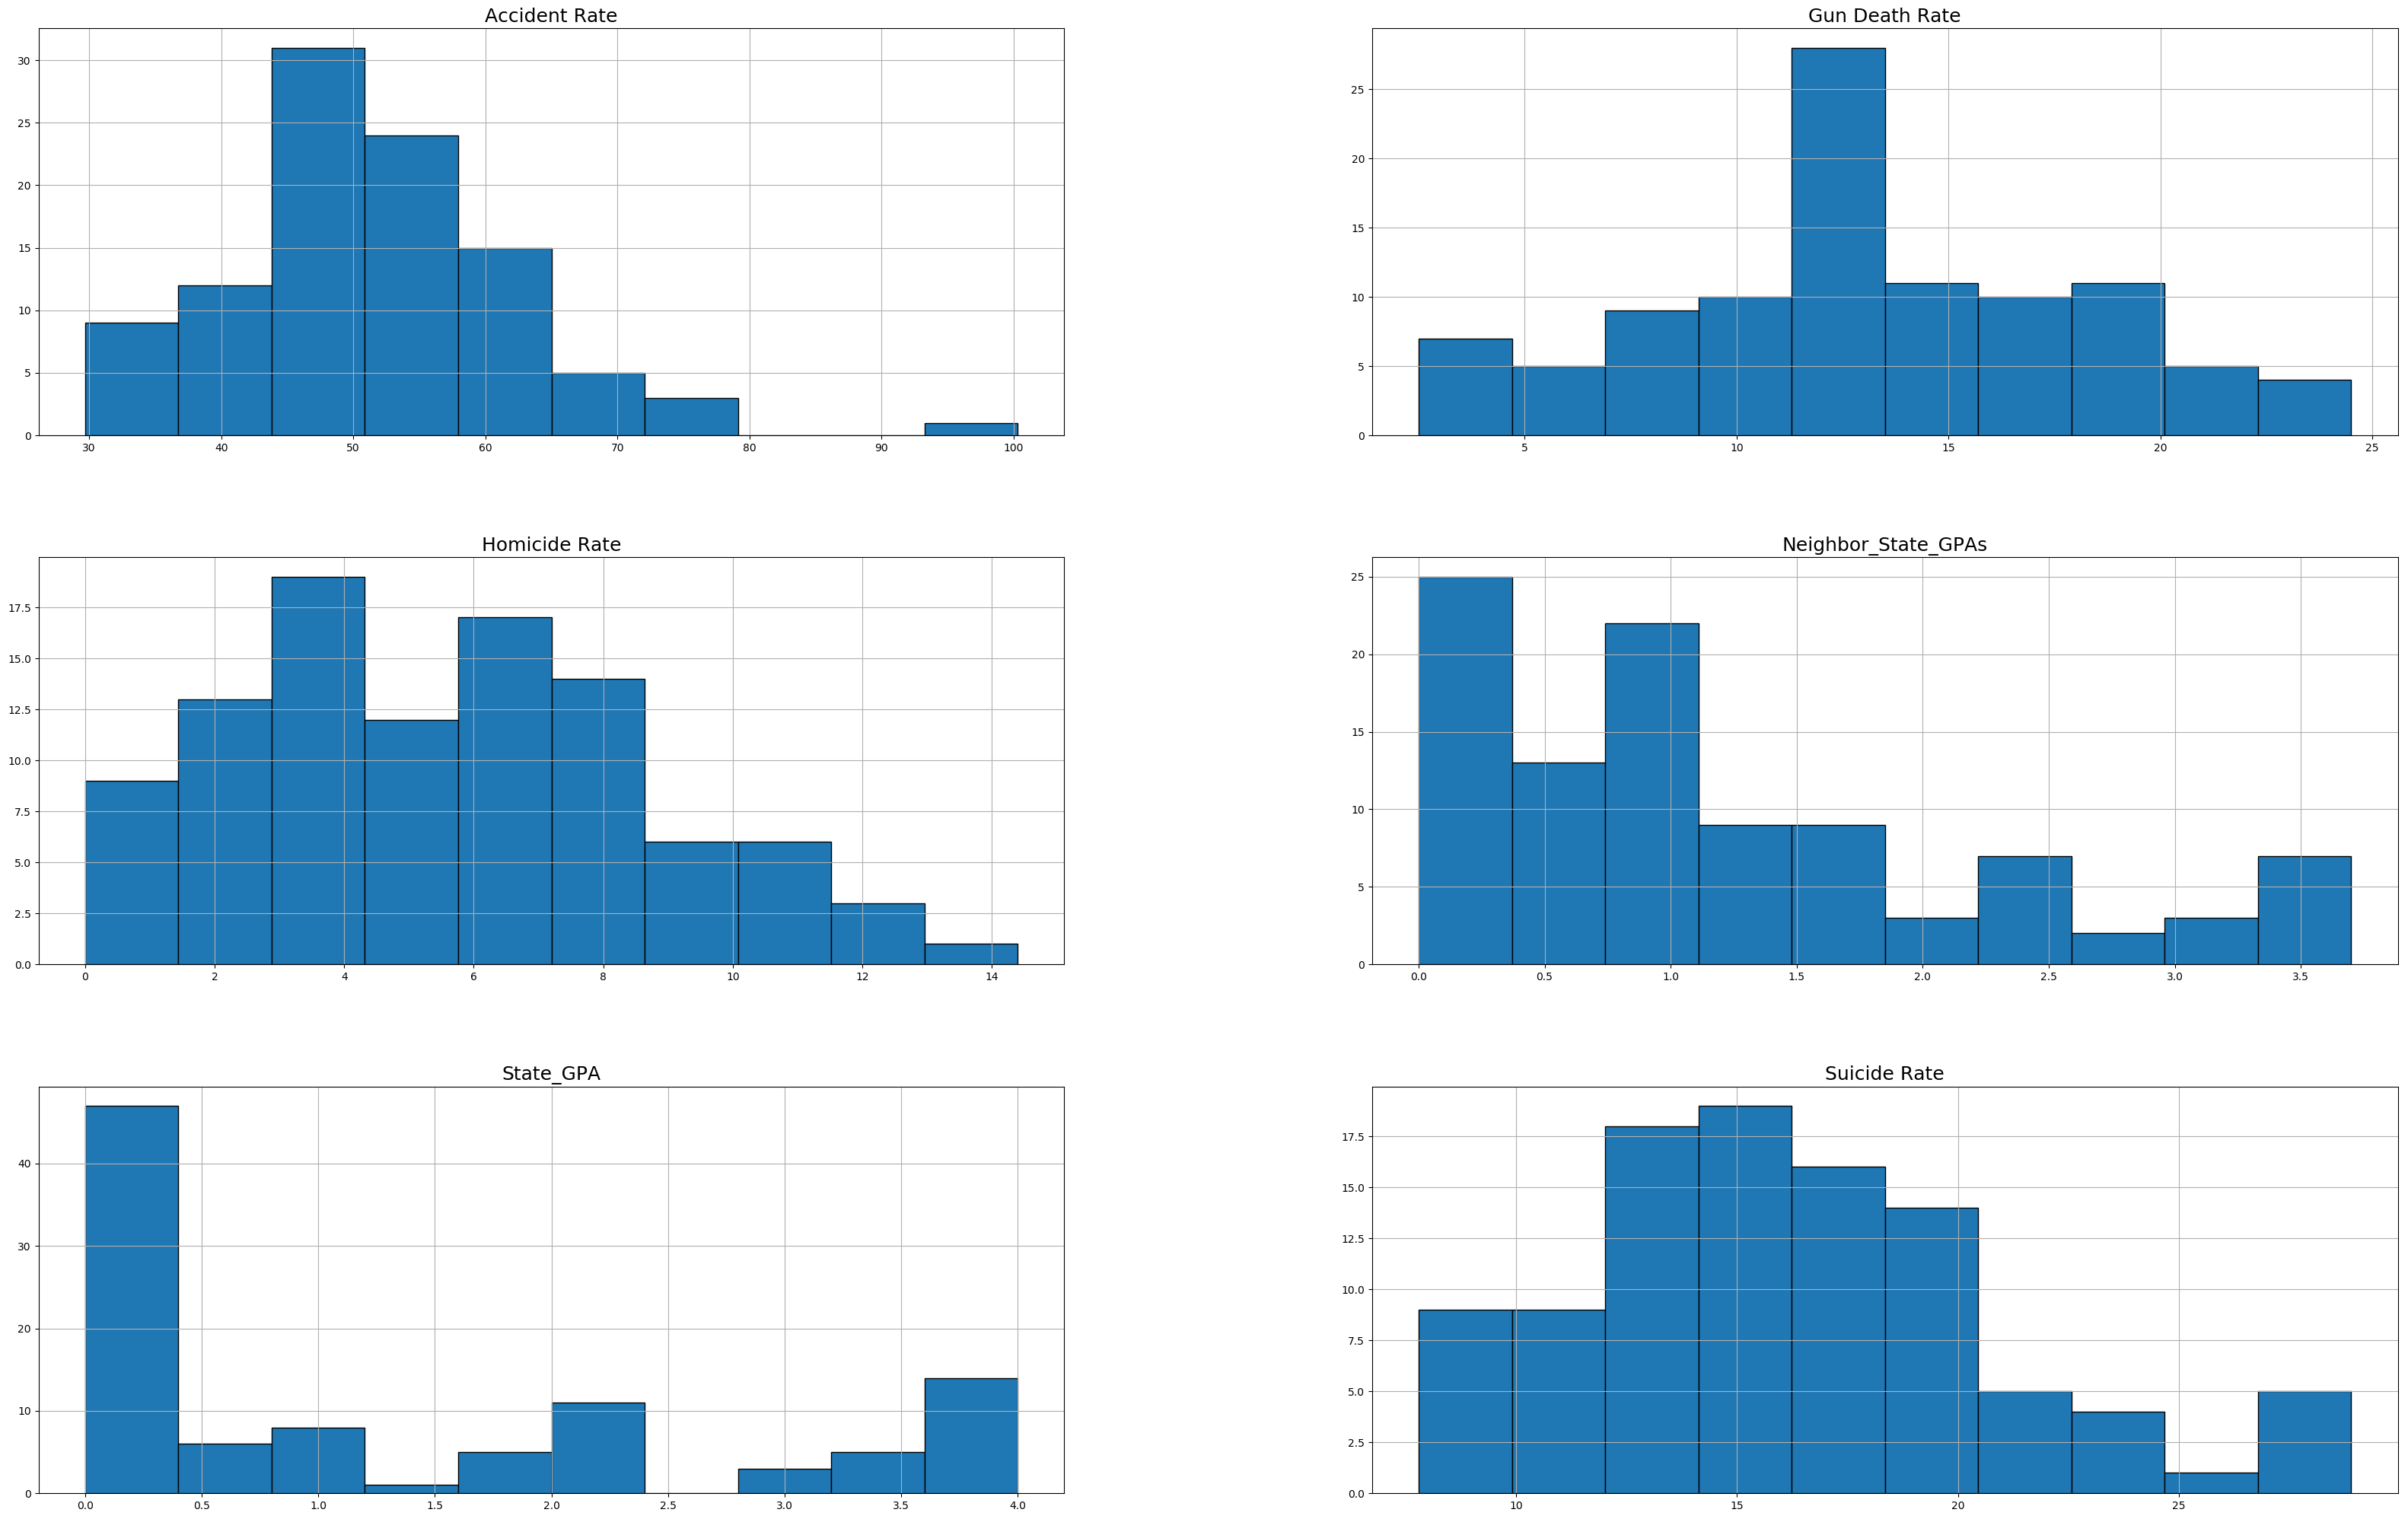

In [18]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# CDC data from 2014 & 2015 invalid
# Save compiled data for later, then filter df
compiled_data = df
df = df[df.Year>2015].reset_index(drop=True)

# View feature distributions
fig = df[df.columns[3:]].hist(figsize = (40, 25), ec='k')
[x.title.set_size(18) for x in fig.ravel()]
plt.show()

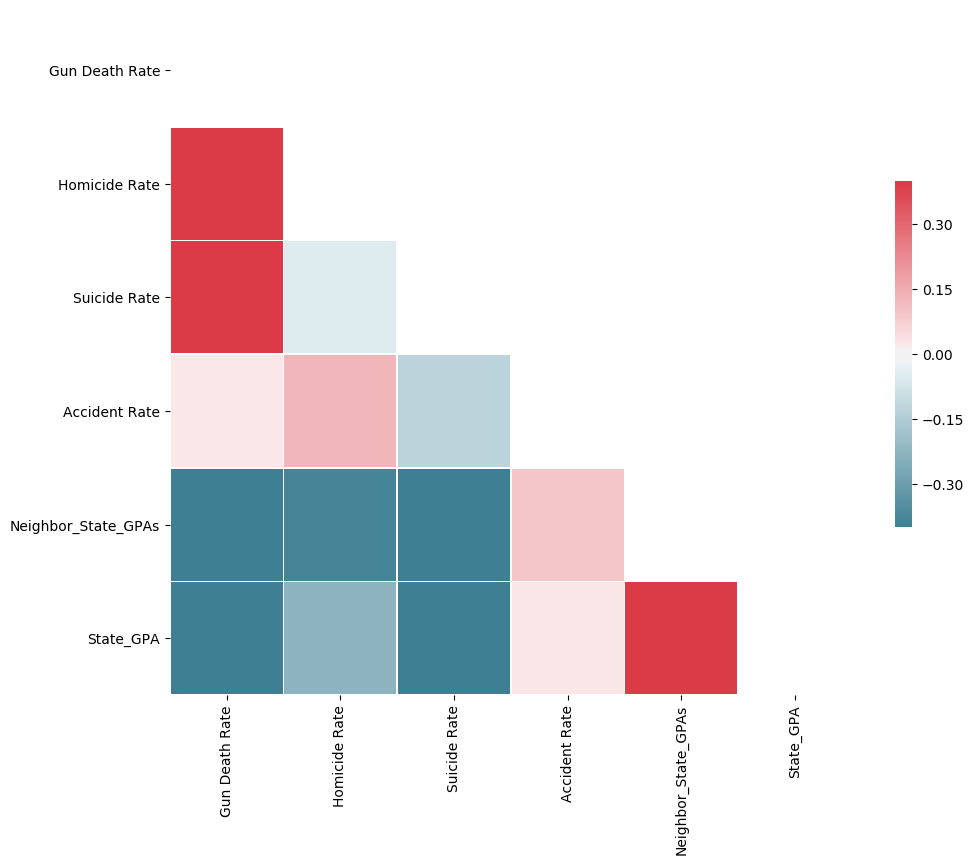

In [19]:
import seaborn as sns

def coll_check(data, size=(11,9)):
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin=-.4, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

coll_check(df[list(df.columns[4:-1]) + ['Neighbor_State_GPAs', 'State_GPA']])

The most notable observation here is that, while the state gun law gpa does seem to have a strong correlatoin with gun death rates, the overall homicide rate appears to be completely unaffected. However, the grades of neighboring states seem to be what matter most in this regard, albeit very slightly. It remains to be seen if the relationship has any statistical significance.

If gun laws do affect gun deaths, it appears most likely to come from reductions in suicide rates.

### Regression Analysis
A simple, linear regression analysis to examine the impact that strength of gun laws have on Gun Death Rates and Homicide Rates.

In [20]:
df.columns

Index(['Year', 'State', 'Grade', 'State_GPA', 'Gun Death Rate',
       'Homicide Rate', 'Suicide Rate', 'Accident Rate',
       'Neighbor_State_GPAs'],
      dtype='object')

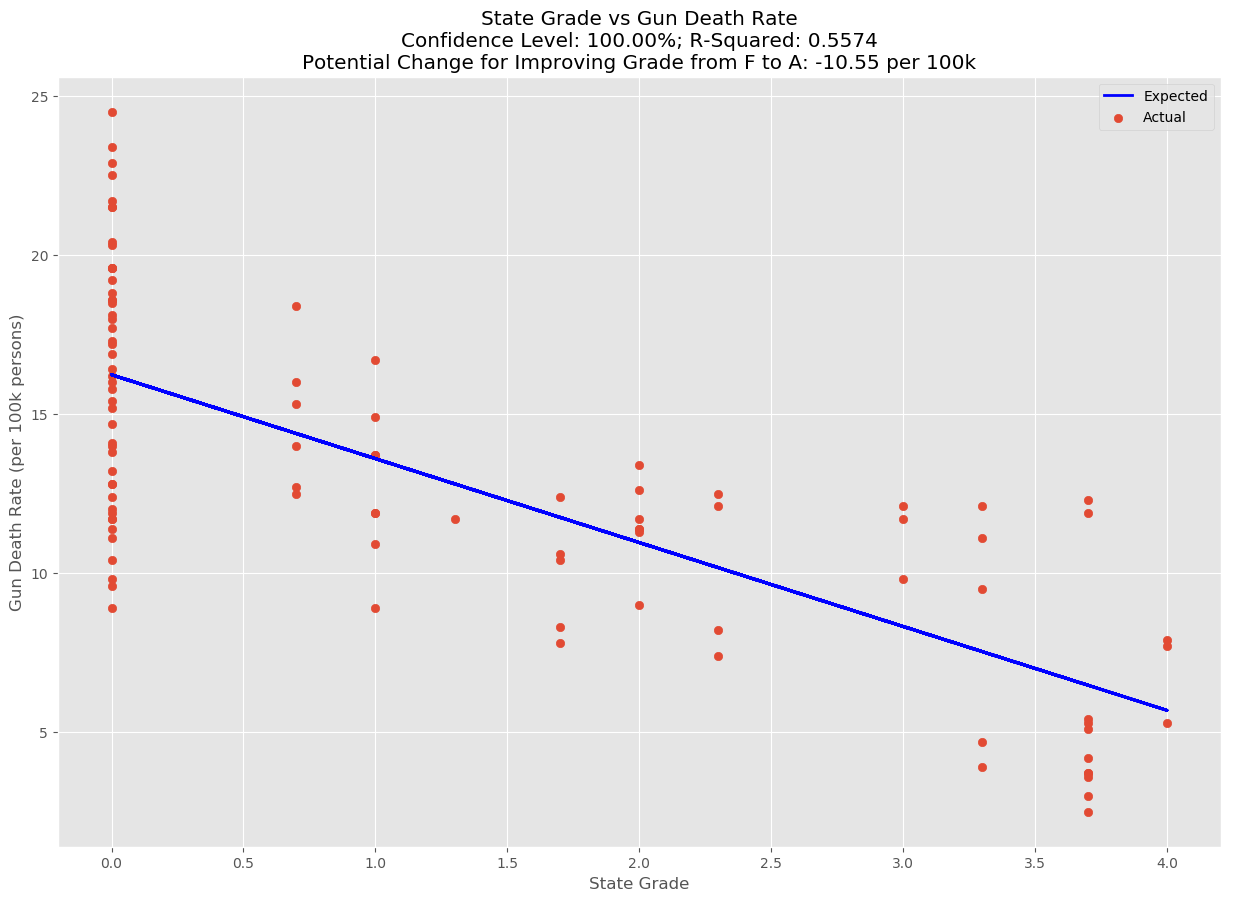

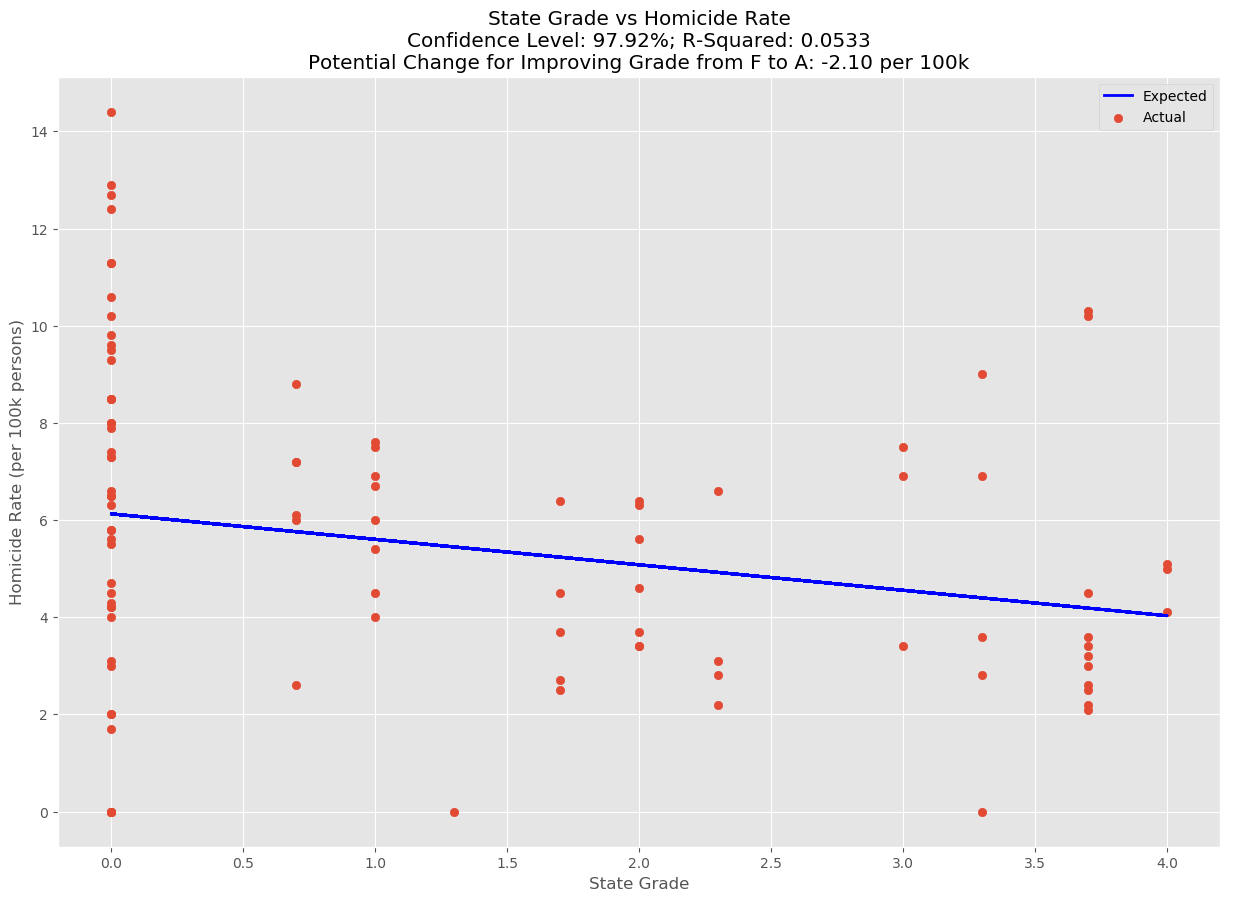

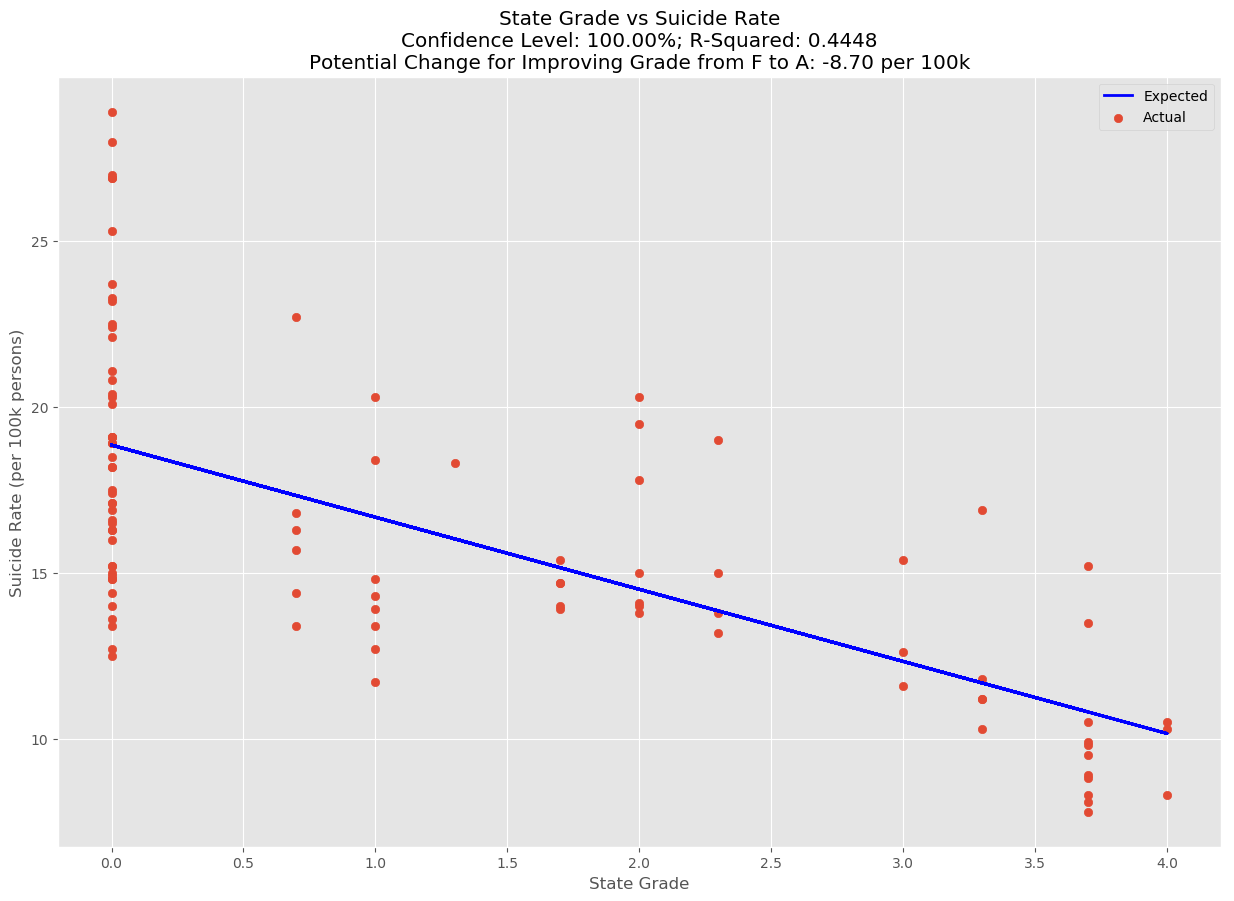

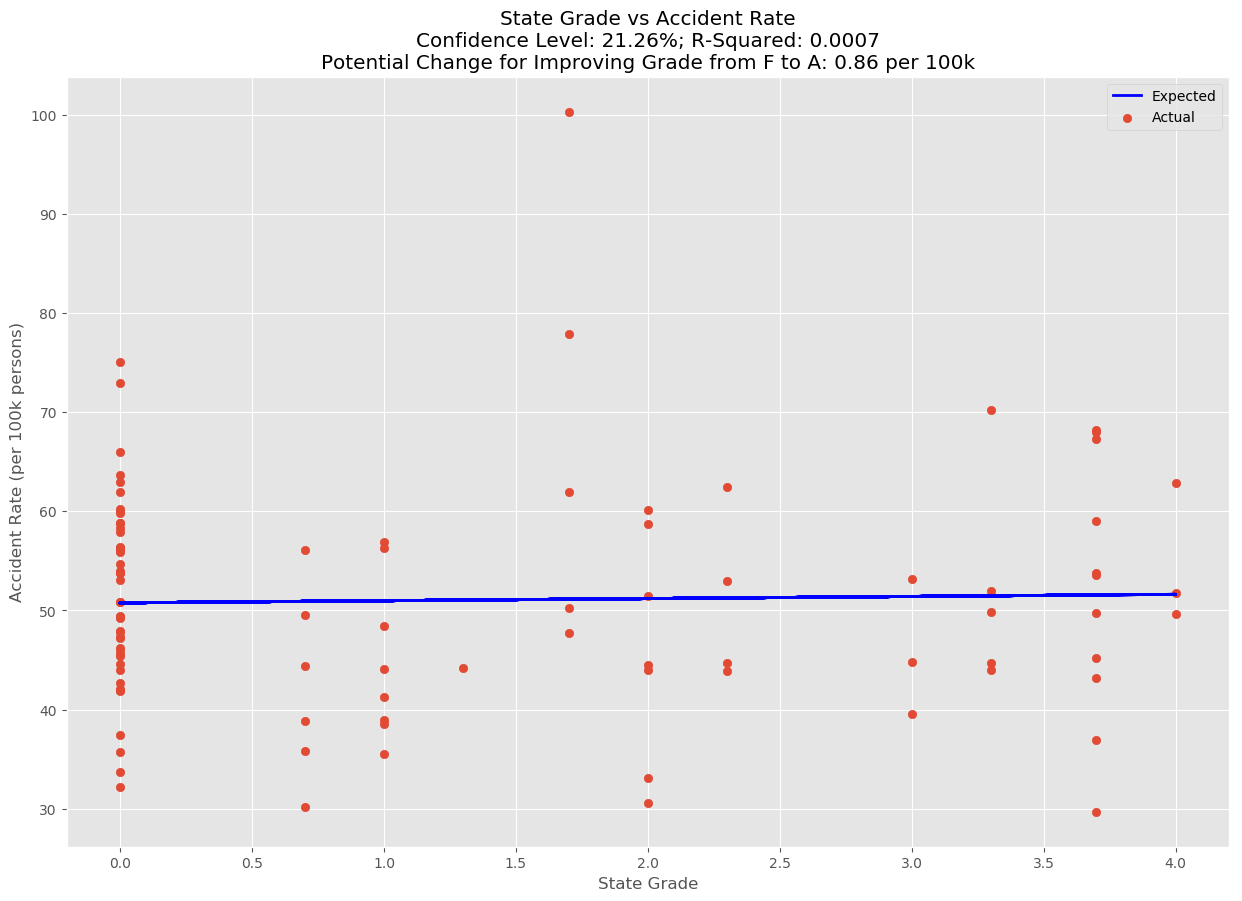

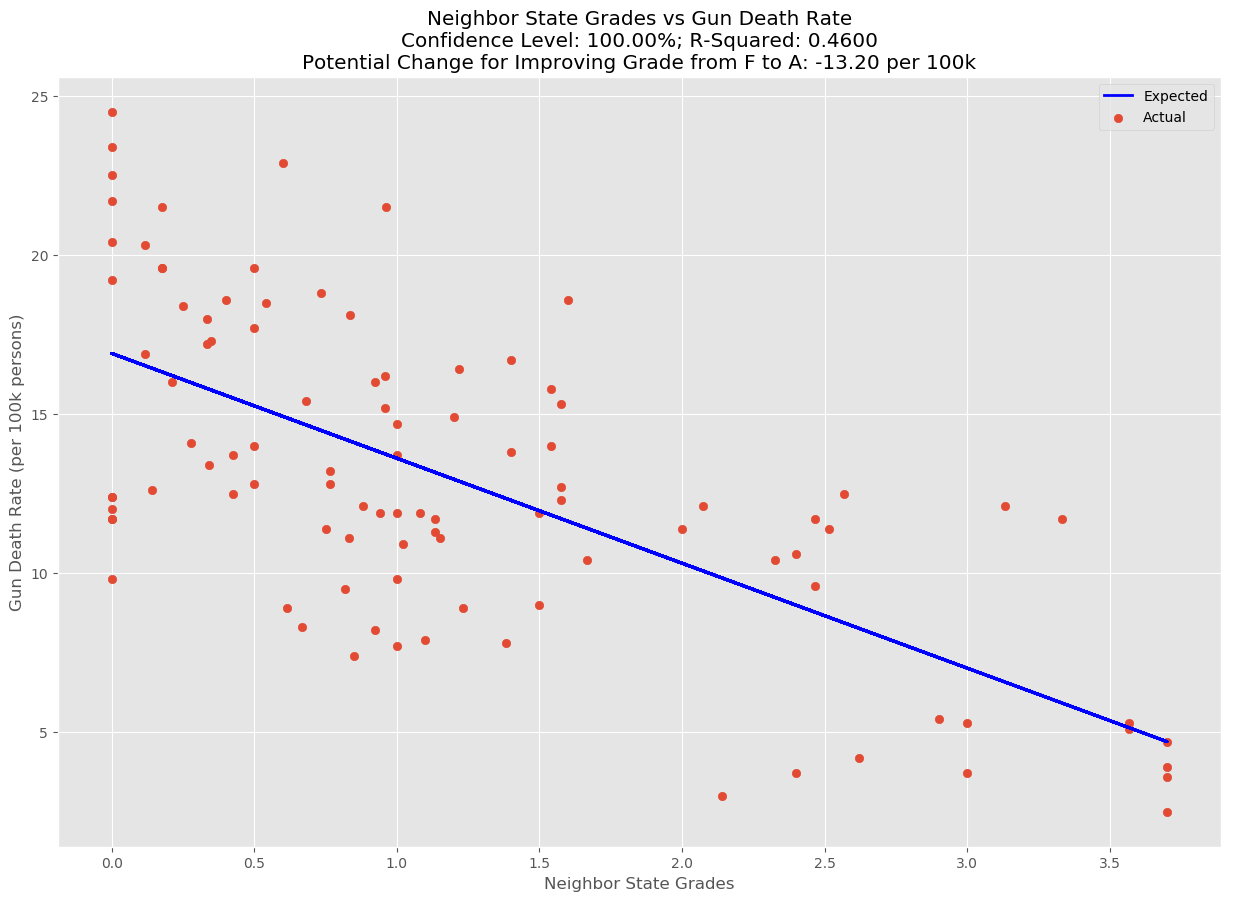

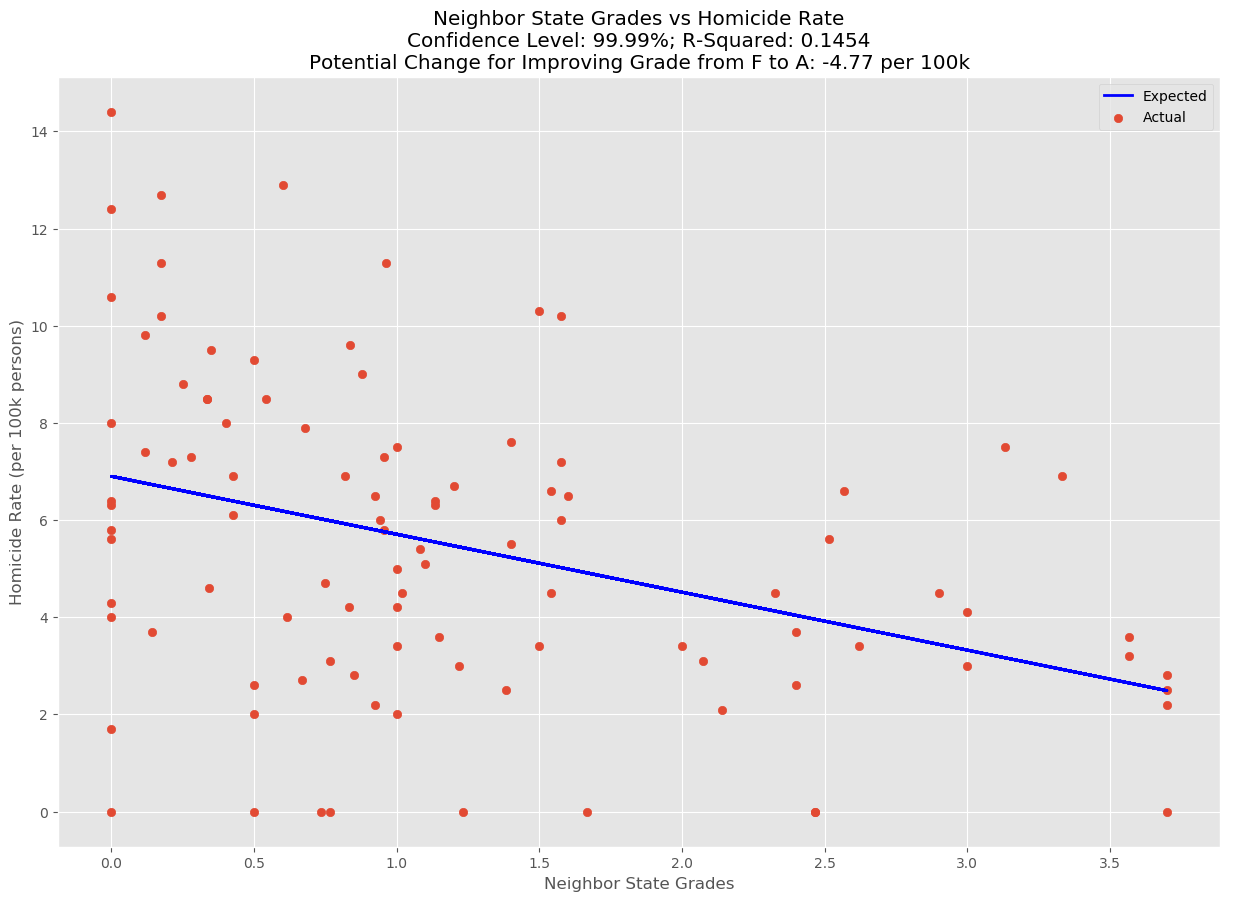

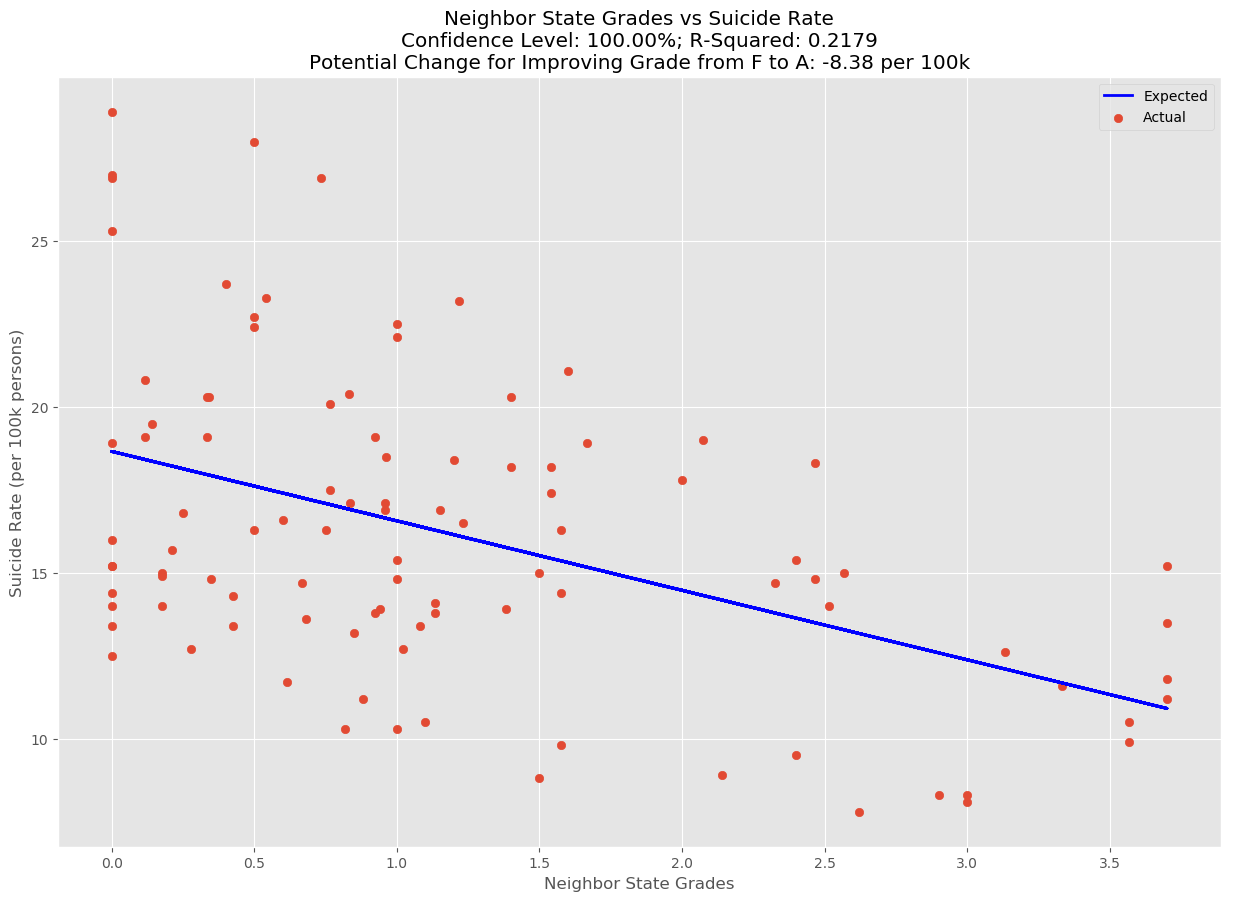

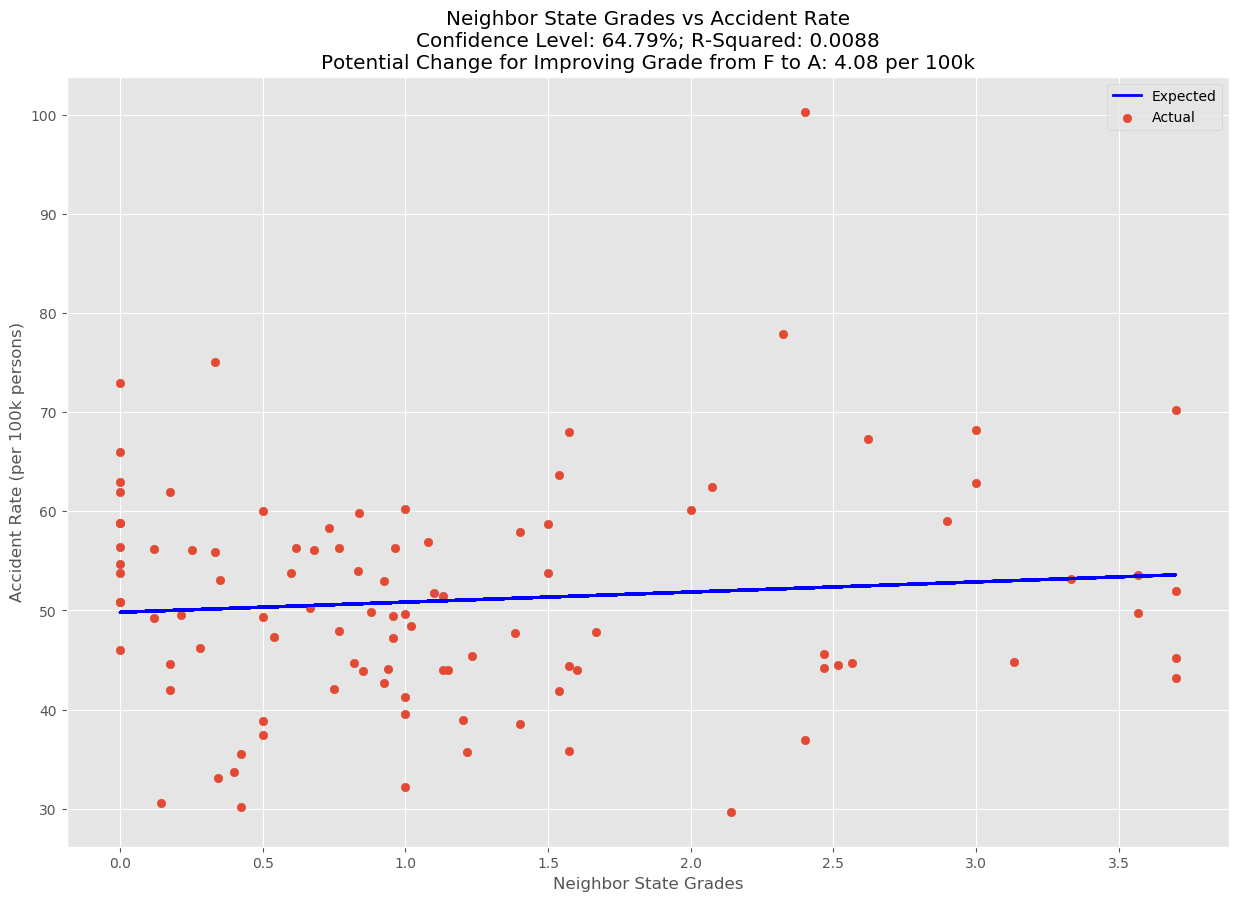

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Gun_Death_Rate,State_GPA,0.557389,16.233778,-2.637583,4.828856e-19
1,Homicide_Rate,State_GPA,0.053291,6.126759,-0.524116,2.084604e-02
2,Suicide_Rate,State_GPA,0.444761,18.850750,-2.174028,3.592538e-14
3,Accident_Rate,State_GPA,0.000746,50.765728,0.214969,7.873780e-01
4,Gun_Death_Rate,Neighbor_State_GPAs,0.459976,16.906921,-3.299133,9.060092e-15
5,Homicide_Rate,Neighbor_State_GPAs,0.145426,6.899352,-1.192140,9.058088e-05
6,Suicide_Rate,Neighbor_State_GPAs,0.217894,18.662553,-2.095221,9.810501e-07
7,Accident_Rate,Neighbor_State_GPAs,0.008840,49.817733,1.019046,3.521260e-01


In [21]:
# Rename columns for regression model
df = df.rename(columns={'Gun Death Rate': 'Gun_Death_Rate', 
                        'Homicide Rate': 'Homicide_Rate', 
                        'Suicide Rate': 'Suicide_Rate', 
                        'Accident Rate': 'Accident_Rate'})

# Set target & predictor variables
targets = list(df.columns[4:-1])
predictors = ['State_GPA', 'Neighbor_State_GPAs']

def regression(df, predictors, targets):
    results = [['Target', 'Predictor', 'R Squared', 'Intercept', 'Slope', 'P Value']]

    for predictor in predictors:
        Predictor = predictor.replace('_', ' ')
        try:
            Predictor = Predictor.replace('State GPA', 'State Grade')
        except:
            pass

        for target in targets:
            Target = target.replace('_', ' ')
            try:
                Target = Target.replace('State GPA', 'State Grade')
            except:
                pass

            if predictor != target:
                # Fit & predict model
                f = f'{target}~{predictor}'
                model = smf.ols(formula=f, data=df).fit()
                y_pred = model.predict()

                # Append list of summary statistics to results
                results.append([target, predictor, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])

                # Plot results
                plt.figure(figsize=(15, 10))
                plt.style.use('ggplot')
                plt.title(f'{Predictor} vs {Target}\n'
                          f'Confidence Level: {100*(1 - model.pvalues[1]):.2f}%; R-Squared: {model.rsquared:.4f}\n'
                          f'Potential Change for Improving Grade from F to A: {model.params[1]*4:.2f} per 100k')
                plt.xlabel(Predictor)
                plt.ylabel(f'{Target} (per 100k persons)')
                plt.scatter(df[predictor], df[target], marker='o', label='Actual')
                plt.plot(df[predictor], y_pred, color='b', lw=2, label='Expected')
                plt.legend()
                plt.show()

        # Create dataframe from results
        result_df = pd.DataFrame(results[1:],columns=results[0])
    return result_df
    
regression(df, predictors, targets)

## Observations
These results make it quite clear that strict gun laws (based on Giffords Law rating) do have a significant impact on overall gun deaths, particularly with regard to suicide deaths. Homicide and accidental deaths remain relatively unaffected. Indeed, the decrease in suicide deaths actually seem to exceed the total firearm deaths, though this slight disparity is likely due to random fluctuations from year to year. 

To ensure the data is properly fitted, a test/train split will be conducted and model tested on unseen data. State grades and neighbor state gpa's will be included in a multi-linear regression.

In [22]:
X = df[['State', 'Year', 'State_GPA']]
y = df['Suicide_Rate']

10% Complete
20% Complete
30% Complete
40% Complete
50% Complete
60% Complete
70% Complete
80% Complete
90% Complete
100% Complete


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


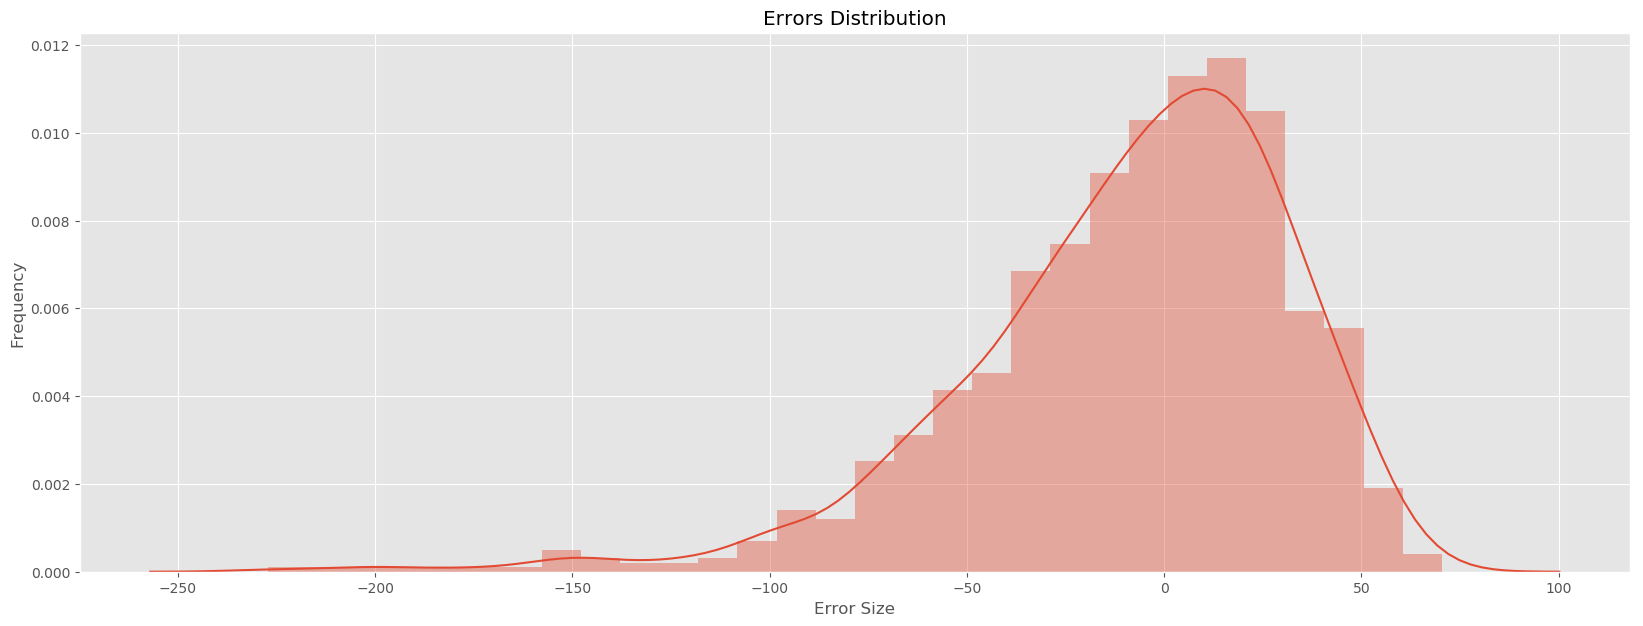

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_linreg(X, y):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25)

    predictions_df = X_test[['State', 'Year']]
    X_train = X_train[[X.columns[-1]]]
    X_test = X_test[[X.columns[-1]]]
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    diff = 100*(train_mse-test_mse)/train_mse

#     print('Train Mean Squared Error: %0.2f' % (train_mse))
#     print('Test Mean Squared Error: %0.2f' % (test_mse))
#     print(f'Performance {"Improvement" if diff>0 else "Deterioration"}: {diff:.2f}%')
    
    predictions_df['Predicted'] = np.round(y_hat_test, 1)
    predictions_df['Actual'] = y_test
    
    
    return predictions_df, diff

errors = []
n=1000
for i in range(n):
    pred_df, diff = train_linreg(X, y)
    errors.append(diff)
    
    if (100 * ((i+1) / n)) % 10 == 0:
        print(f'{int(100 * (i+1)/n)}% Complete')
          
plt.figure(figsize=(20, 7))
sns.distplot(errors)
plt.title('Errors Distribution')
plt.xlabel('Error Size')
plt.ylabel('Frequency')
plt.show()

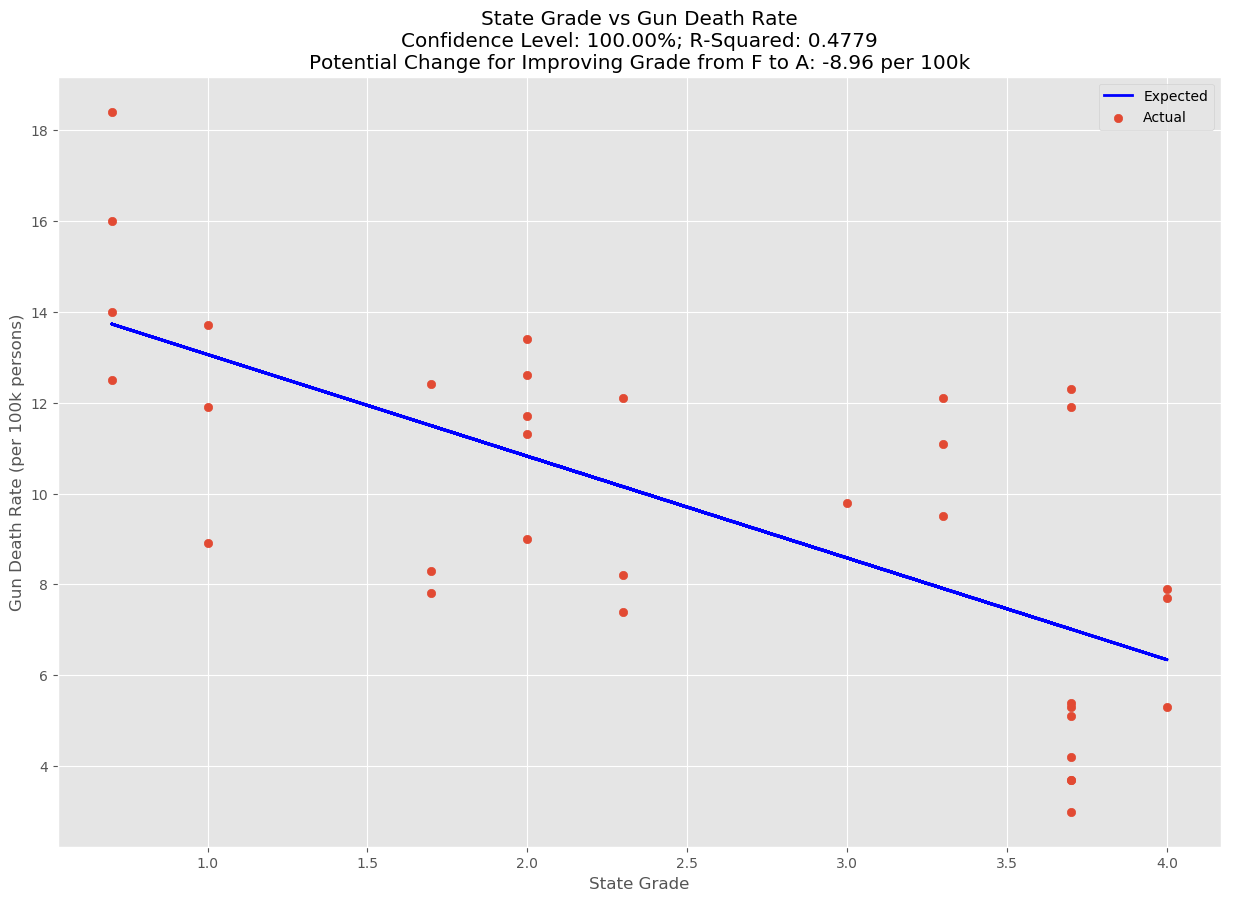

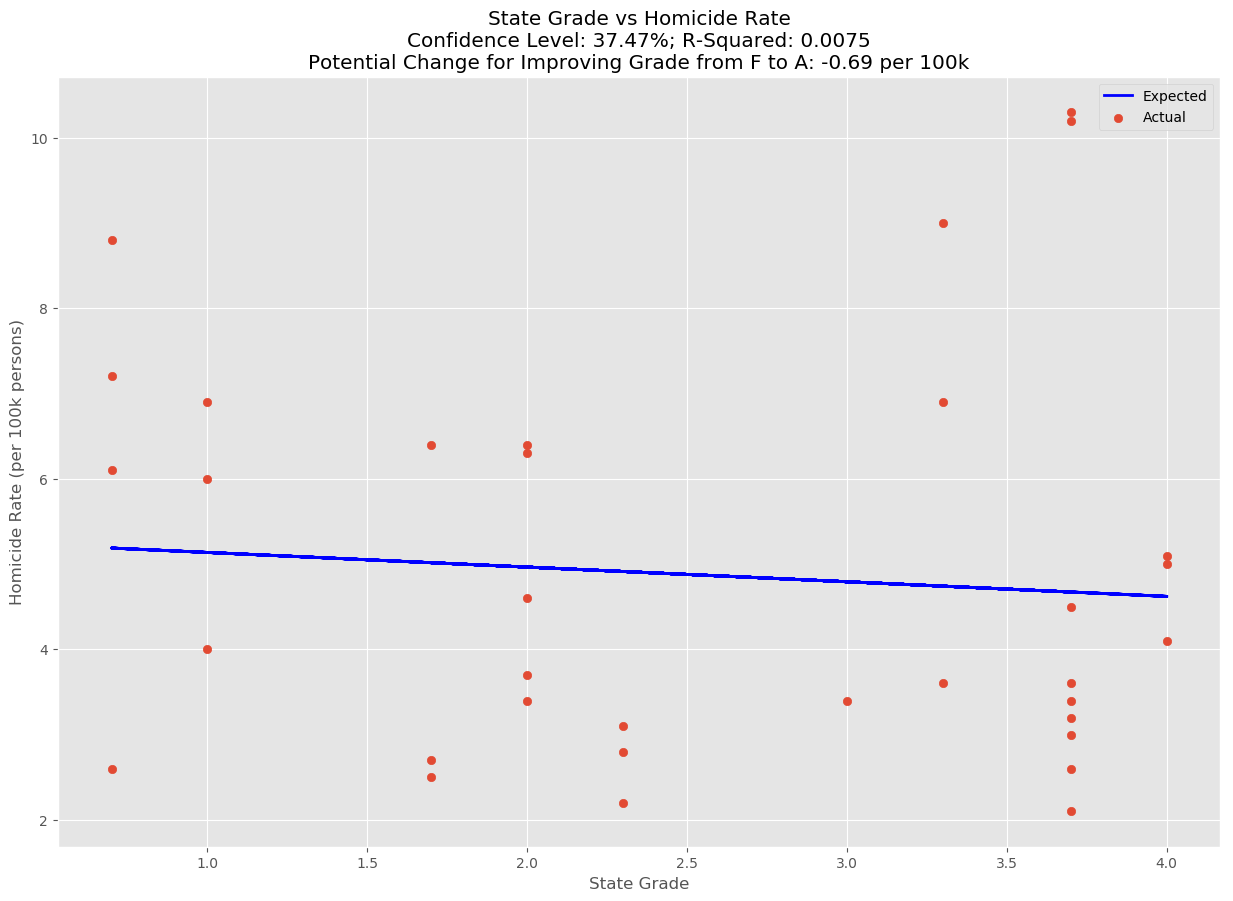

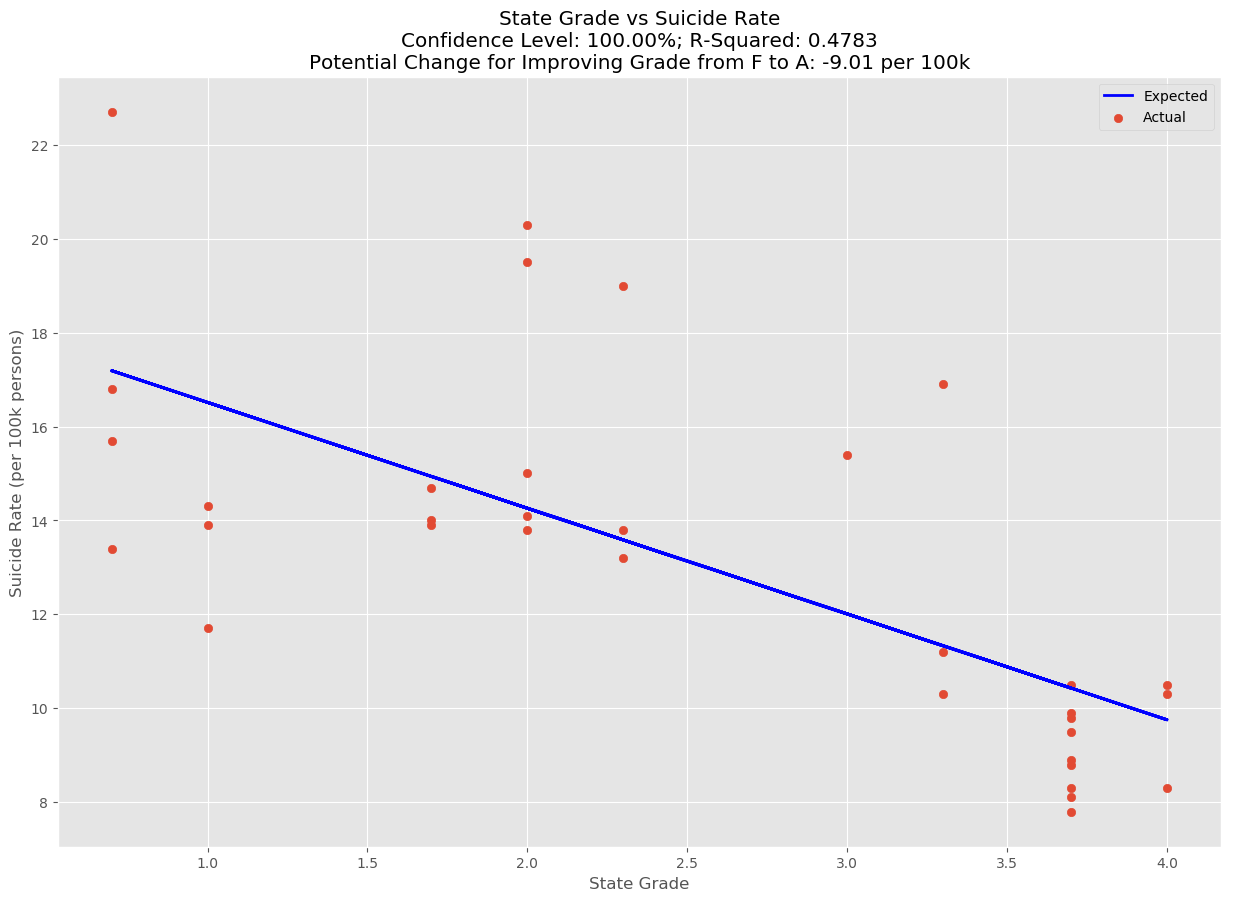

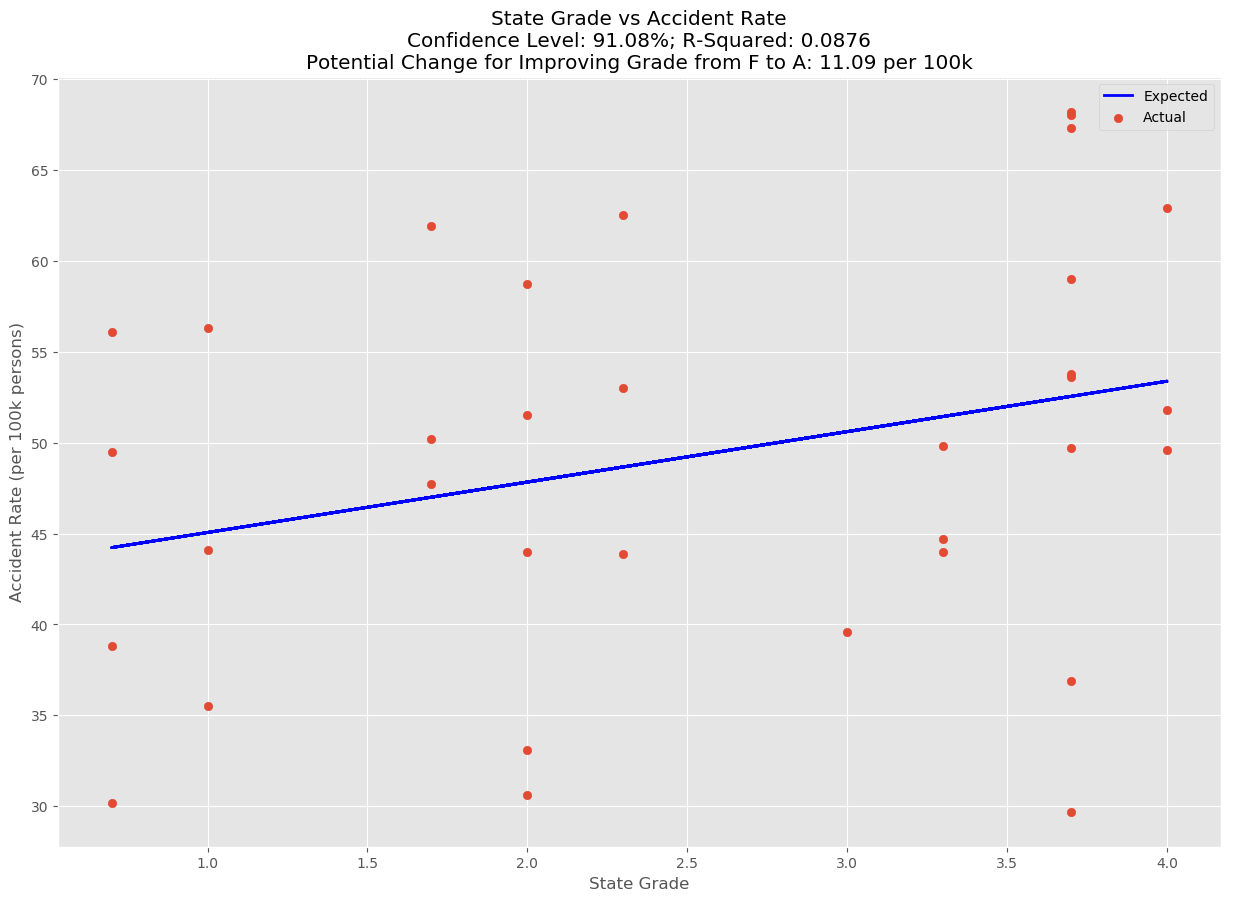

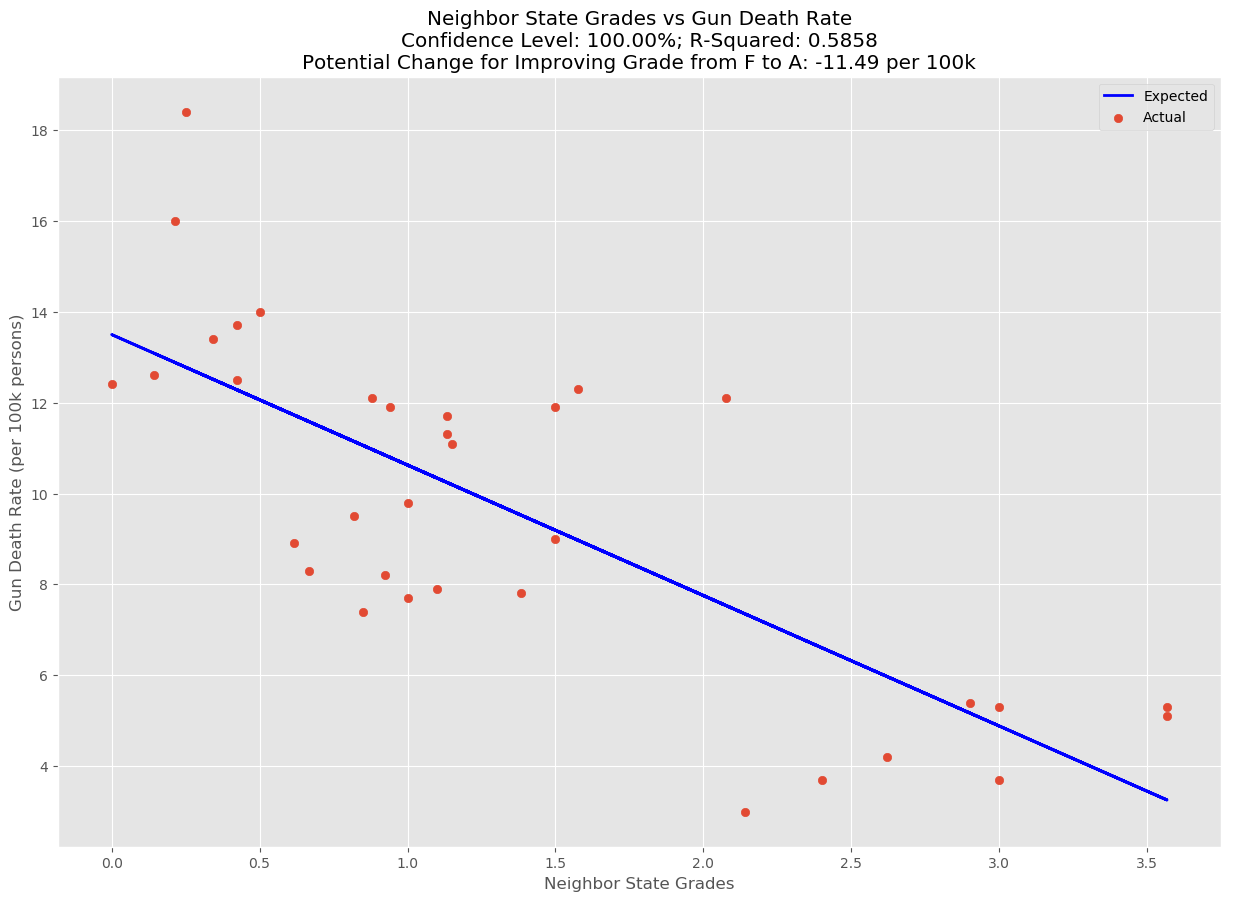

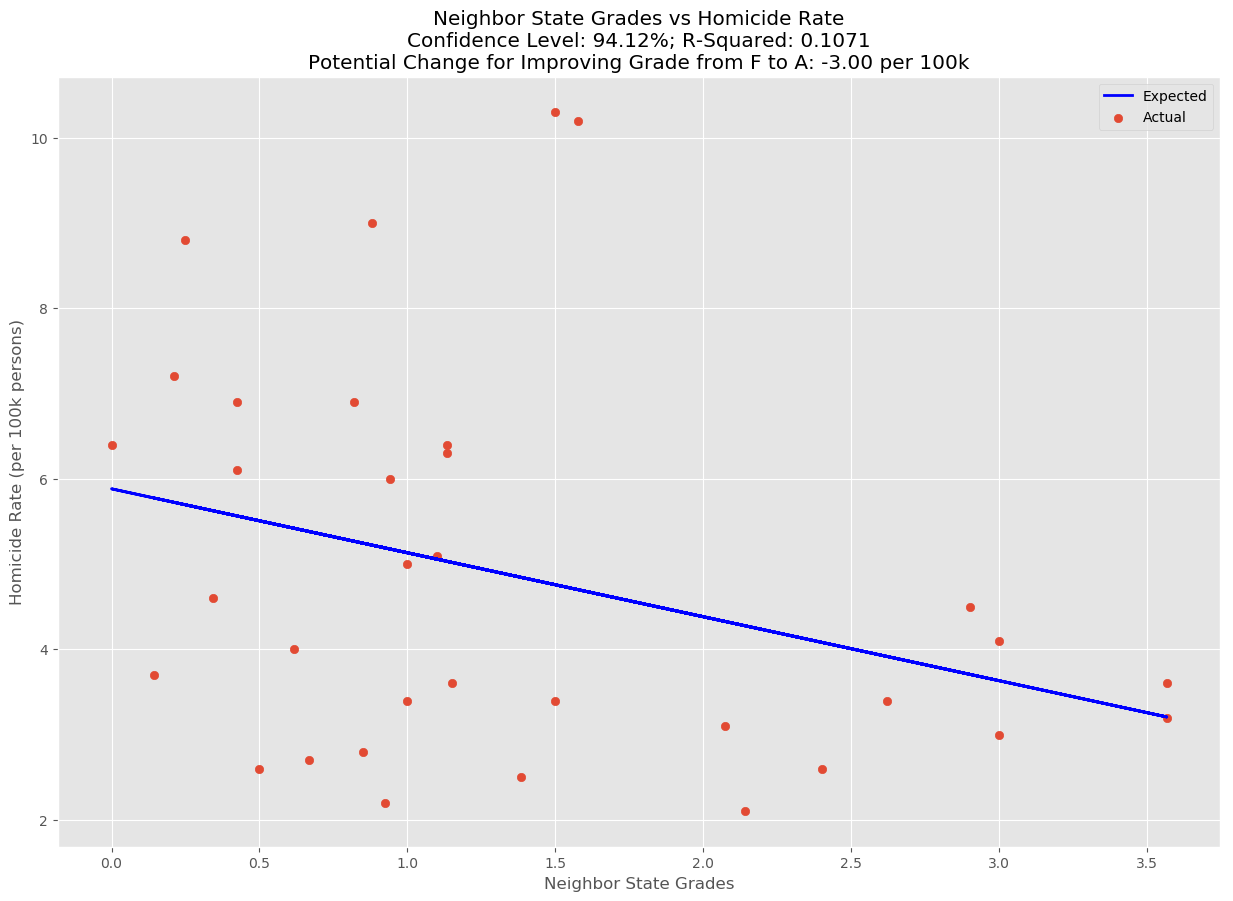

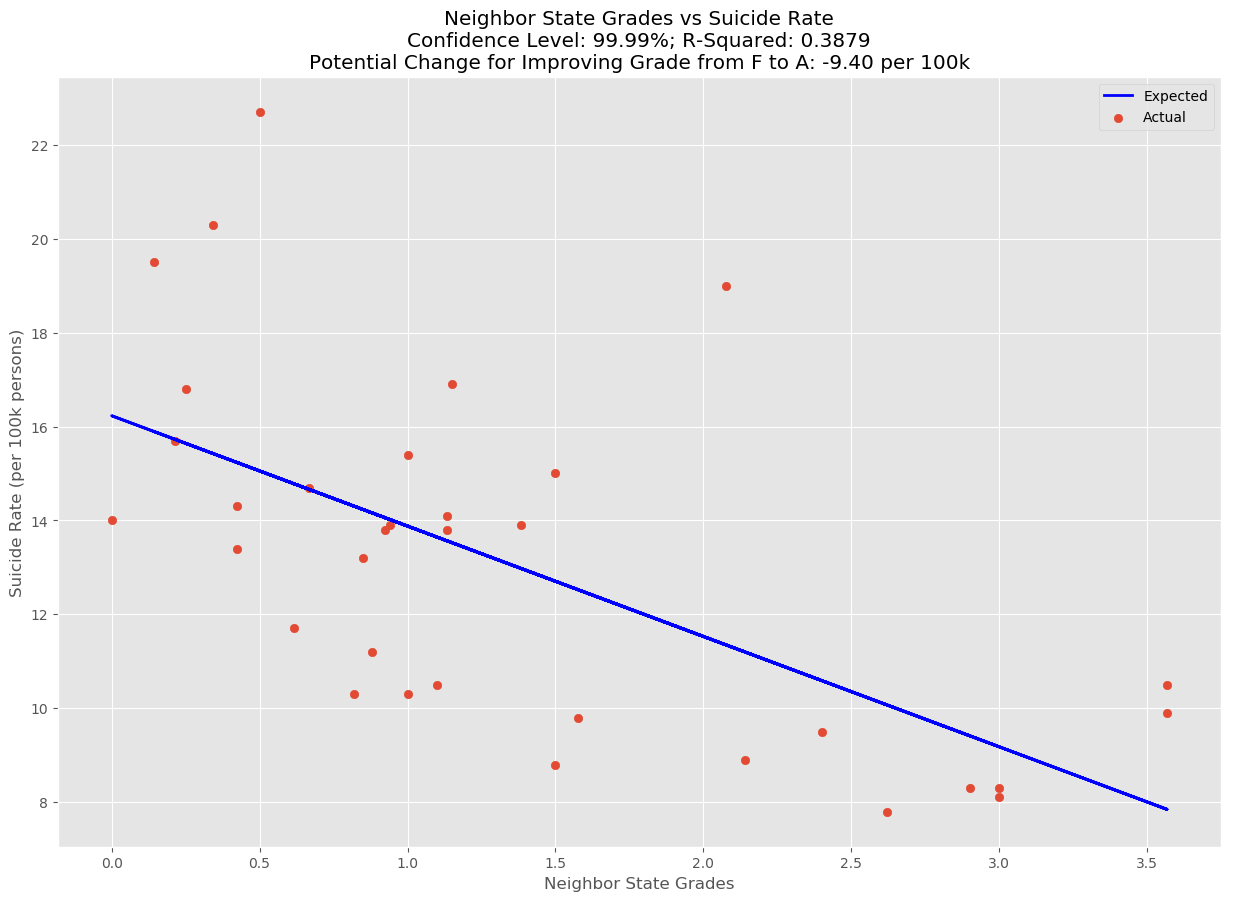

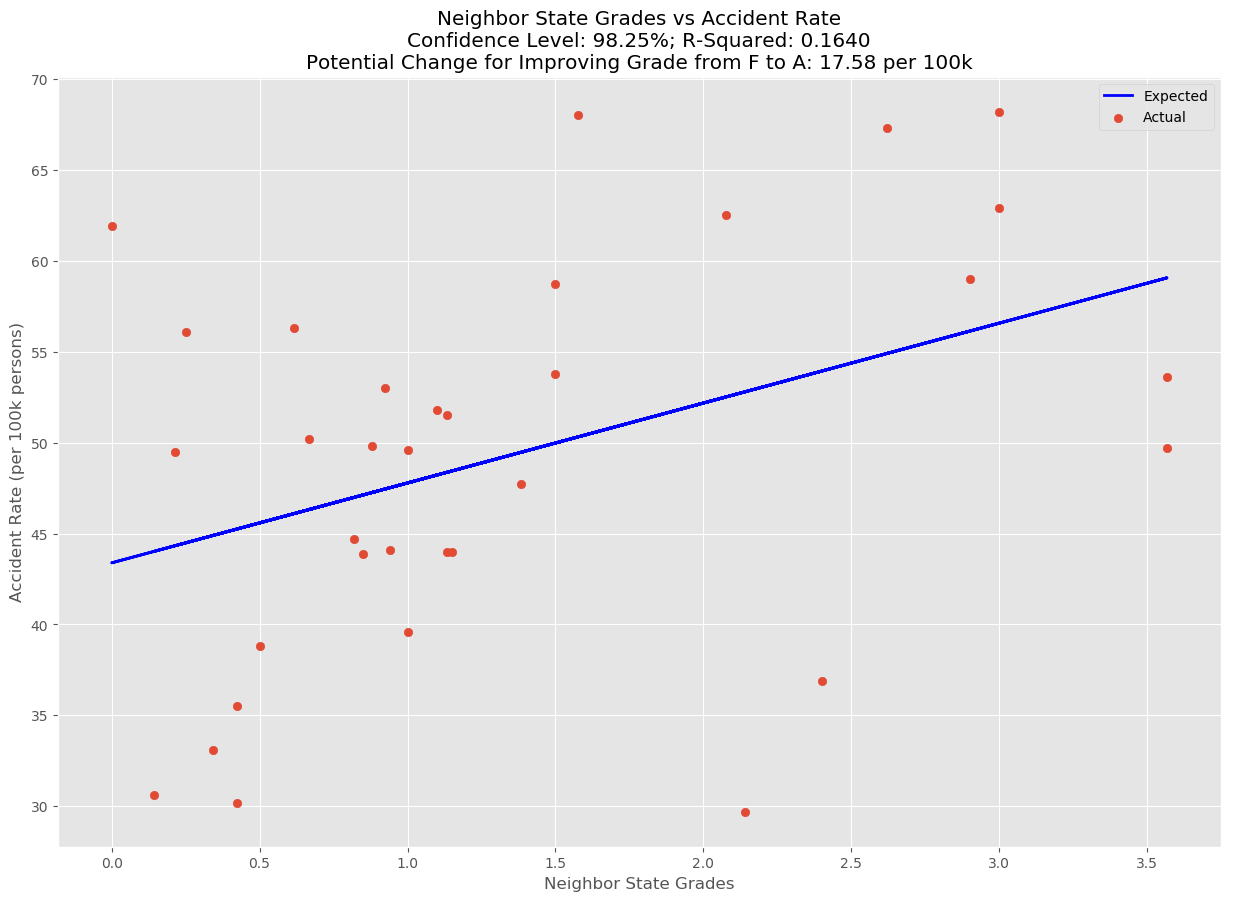

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Gun_Death_Rate,State_GPA,0.477851,15.298355,-2.238885,5.997936e-06
1,Homicide_Rate,State_GPA,0.007543,5.307981,-0.171760,6.252752e-01
2,Suicide_Rate,State_GPA,0.478326,18.765807,-2.252761,5.908582e-06
3,Accident_Rate,State_GPA,0.087623,42.284852,2.773431,8.916756e-02
4,Gun_Death_Rate,Neighbor_State_GPAs,0.585849,13.499082,-2.872084,1.342737e-07
5,Homicide_Rate,Neighbor_State_GPAs,0.107135,5.882464,-0.749975,5.881305e-02
6,Suicide_Rate,Neighbor_State_GPAs,0.387900,16.229546,-2.350346,8.364621e-05
7,Accident_Rate,Neighbor_State_GPAs,0.163996,43.386304,4.395851,1.751136e-02


In [24]:
df['Weak_Neighbors'] = df.Neighbor_State_GPAs - df.State_GPA
weak_neighbors_df = df[df.Weak_Neighbors < 0]
targets = df.columns[4:8]
predictors = ['State_GPA', 'Neighbor_State_GPAs']

regression(weak_neighbors_df, predictors, targets)

10% Complete
20% Complete
30% Complete
40% Complete
50% Complete
60% Complete
70% Complete
80% Complete
90% Complete
100% Complete


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


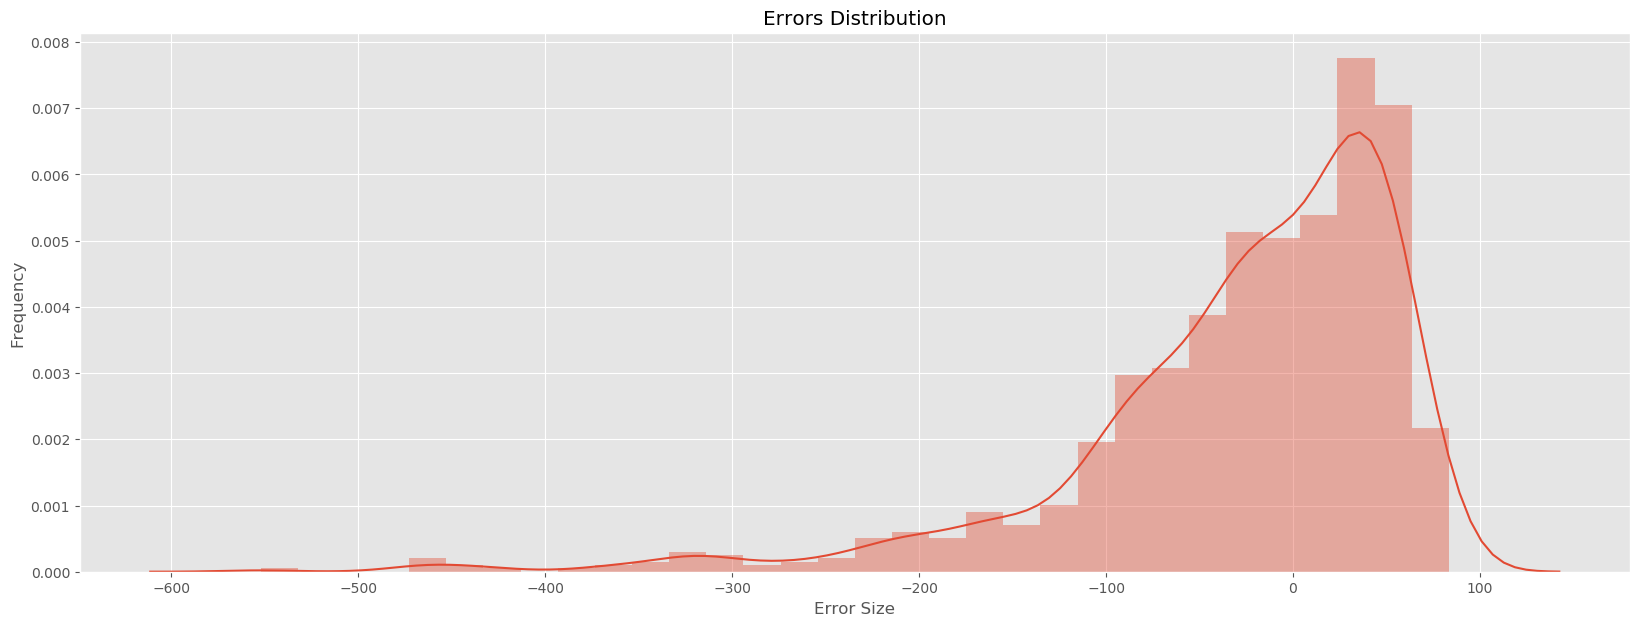

In [25]:
X = weak_neighbors_df[['State', 'Year', 'Neighbor_State_GPAs']]
y = weak_neighbors_df['Homicide_Rate']

errors = []
n=1000
for i in range(n):
    pred_df, diff = train_linreg(X, y)
    errors.append(diff)
    
    if (100 * ((i+1) / n)) % 10 == 0:
        print(f'{int(100 * (i+1)/n)}% Complete')
          
plt.figure(figsize=(20, 7))
sns.distplot(errors)
plt.title('Errors Distribution')
plt.xlabel('Error Size')
plt.ylabel('Frequency')
plt.show()

Test performance was better than training performance when looking at state grade as the sole predictor.

## Multilinear Regression
It seems surrounding state grades may have an impact as well, but we should check this in tandem with state laws to see which, if either, has a stronger impact.

In [50]:
for data in [df, weak_neighbors_df]:
    for target in ['Homicide_Rate', 'Suicide_Rate']:
        f = f'{target}~+State_GPA+Neighbor_State_GPAs'
        model = smf.ols(formula=f, data=data).fit()
        print(model.summary())
        print('\n\n\n')

                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     8.360
Date:                Tue, 20 Aug 2019   Prob (F-statistic):           0.000447
Time:                        03:37:20   Log-Likelihood:                -251.59
No. Observations:                 100   AIC:                             509.2
Df Residuals:                      97   BIC:                             517.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.8850    

## Conclusions
### Suicide
The results are clear that stronger gun laws have a substantial and significant impact on suicide rates. In addition to p-value and r-squared values, the test performance was improved over training results using RMSE as the key metric. The OLS summary revealed, however, that neighboring states have less impact than seems at first glance. These rates are directly tied to gun laws within the state. 

Given that the national suicide rate in 2017 was 14 per 100,000, half of all suicides result from gun deaths, and states that have an A rating have an average 5 fewer suicides as a direct result of those laws, it can be estimated that if F-rated states improve their laws to meet the A-rating, suicide deaths might be reduced by an average 35% in those states.

### Homicide / Accidental Deaths
The reduction in suicide deaths account for practically all of the reductions in firearm deaths, with almost no impact on homicide or accidental deaths. What is unknown is whether criminals use alternate means of committing homicides, or if they simply don't disarm. Without a distinction made between firearm and non-firearm homicides at the state level, this will not be possible to determine. However, by looking at data on an international level, comparing results across nations, we may be able to get more incite.

# Getting More Data
## Mass Murders
Dataset downloaded from the University of Maryland's [Global Terrorism Database](https://www.start.umd.edu/gtd). Mass shootings are defined as those where the total number of fatalities is 6 or more. Filters were applied to gather data only in the United States where firearms was a weapon of choice. All weapons types were considered, with the exception of CBD. In addition, failed attemps will also be considered, so instances where injuries are 10+ or fatalities exceed 5 will be included.

In [27]:
# url = str('https://www.start.umd.edu/gtd/search/ResultsCSV.aspx?csv=1&'
#           'casualties_type=b&casualties_max=&start_yearonly=1991&end_year'
#           'only=2017&dtp2=all&success=no&country=217&weapon=6,7,5,8,9,11,13,10')

# mass_shooting_data = pd.read_csv(url, usecols=np.arange(20))
# mass_shooting_data.to_csv('national_data/mass_shootings.csv')

mass_shooting_data = pd.read_csv('national_data/mass_shootings.csv')

cols = [2, 4, 12, 11, -1]
mass_shooting_data = mass_shooting_data[mass_shooting_data.columns[cols]]
mass_shooting_data.head()

,DATE,CITY,INJURED,FATALITIES,WEAPON TYPE 1
0,2017-12-22,Harrisburg,1,1,Firearms
1,2017-12-22,Harrisburg,0,0,Firearms
2,2017-12-11,New York City,4,0,Explosives/Bombs/Dynamite
3,2017-12-07,Aztec,0,3,Firearms
4,2017-11-13,Vale,0,0,Incendiary


In [28]:
for col in ['FATALITIES', 'INJURED']:
    clean_col = []
    for item in mass_shooting_data[col]:
        try:
            clean_col.append(int(item))
        except:
            clean_col.append(0)
    mass_shooting_data[col] = clean_col
    mass_shooting_data = mass_shooting_data.rename(columns={col:col.title()})

mass_shooting_data = mass_shooting_data[(mass_shooting_data['Fatalities']>=6) | (mass_shooting_data['Injured'] >= 10)]

mass_shooting_data['Year'] = [int(date[:4]) for date in mass_shooting_data['DATE']]
mass_shooting_data = mass_shooting_data.reset_index(drop=True)

mass_shooting_data

,DATE,CITY,Injured,Fatalities,WEAPON TYPE 1,Year
0,2017-10-31,New York City,13,8,Vehicle (not to include vehicle-borne explosives,2017
1,2017-10-01,Las Vegas,851,59,Firearms,2017
2,2017-08-12,Charlottesville,19,1,Vehicle (not to include vehicle-borne explosives,2017
3,2016-11-28,Columbus,11,1,Melee,2016
4,2016-09-17,St. Cloud,10,1,Melee,2016
5,2016-09-17,New York City,29,0,Explosives/Bombs/Dynamite,2016
6,2016-07-07,Dallas,9,6,Firearms,2016
7,2016-06-12,Orlando,53,50,Firearms,2016
8,2015-12-02,San Bernardino,17,16,Explosives/Bombs/Dynamite,2015
9,2015-10-01,Roseburg,7,10,Firearms,2015


### Manual Inspection of Data
Incidents that use weapons that would not be seen as an effective substitute for unavailability of guns will be dropped. For example, use of planes on 9/11 could hardly be seen as an alternative weapon of choice because of gun restrictions. A list of index numbers will be used to clearly identify which items will be dropped.

In [29]:
to_drop = [5, 13, 15, 16, 20, 21, 22, 23, 28]
mass_shooting_data = mass_shooting_data.drop(to_drop)

# Change San Bernardino to firearm
mass_shooting_data.loc[8,'WEAPON TYPE 1'] = 'Firearms'

mass_shooting_data['State'] = ['New York', 
                               'Nevada', 
                               'Virginia', 
                               'Ohio', 
                               'Minnesota', 
                               'Texas', 
                               'Florida', 
                               'California', 
                               'Oregon', 
                               'Tennessee', 
                               'South Carolina', 
                               'California', 
                               'Texas', 
                               'Wisconsin', 
                               'Texas', 
                               'Texas', 
                               'Colorado', 
                               'Georgia', 
                               'New York', 
                               'Arizona']

mass_shooting_data['State-Year'] = mass_shooting_data.State + ' ' + mass_shooting_data.Year.astype('str')
mass_shooting_data = mass_shooting_data.rename(columns={'WEAPON TYPE 1': 'Attack Type', 'CITY': 'City'})
mass_shooting_data = mass_shooting_data[['State-Year', 'City', 'Injured', 'Fatalities', 'Attack Type']].set_index('State-Year')
mass_shooting_data['Attack Type'] = ['Mass Shooting' if weapon=='Firearms' else 'Other Attack' for weapon in mass_shooting_data['Attack Type']]
mass_shooting_data

,City,Injured,Fatalities,Attack Type
State-Year,,,,
New York 2017,New York City,13,8,Other Attack
Nevada 2017,Las Vegas,851,59,Mass Shooting
Virginia 2017,Charlottesville,19,1,Other Attack
Ohio 2016,Columbus,11,1,Other Attack
Minnesota 2016,St. Cloud,10,1,Other Attack
Texas 2016,Dallas,9,6,Mass Shooting
Florida 2016,Orlando,53,50,Mass Shooting
California 2015,San Bernardino,17,16,Mass Shooting
Oregon 2015,Roseburg,7,10,Mass Shooting


## Homicide Counts
### 2014 - 2017
Data accessed from CDC's [National Center for Health Statistics](https://www.cdc.gov/nchs/pressroom/sosmap/homicide_mortality/homicide.htm) (NCHS).

In [30]:
homicide_counts = pd.read_csv('national_data/Homicide Mortality by State.csv').dropna()
homicide_counts['State'] = [state_abbrs[st] for st in homicide_counts['STATE']]
homicide_counts = homicide_counts.drop(['STATE', 'URL', 'RATE'], axis=1)
homicide_counts['YEAR'] = homicide_counts['YEAR'].astype('int')
homicide_counts['DEATHS'] = [int(count.replace(',', '')) for count in homicide_counts['DEATHS']]
homicide_counts = homicide_counts.rename(columns={'YEAR': 'Year', 
                                                  'DEATHS': 'Deaths'})
homicide_counts = homicide_counts[homicide_counts['Year']>2014]
homicide_counts.head()

,Year,Deaths,State
0,2017,602,Alabama
1,2017,78,Alaska
2,2017,441,Arizona
3,2017,278,Arkansas
4,2017,2022,California


### 1991 - 2014
Data scraped from the FBI's Uniform Crime Reporting Statistics (UCRS) [website](https://www.ucrdatatool.gov/Search/Crime/State/RunCrimeStatebyState.cfm).

In [31]:
table_names = state_names[:50]
table_names.append('District of Columbia')
table_names = sorted(table_names)
table_names[:10]

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida']

In [32]:
state_homicide_dfs = {}

def get_state_tables(index, i):
    if index in list(range(32*i + 9, 32*i+34)):
        return False
    
    else:
        return True

for i in range(51):
    state_homicide_dfs[table_names[i]] = pd.read_csv('national_data/CrimeStatebyState.csv', 
                                            skiprows= lambda x: get_state_tables(x, i))

for table in state_homicide_dfs.keys():
    if table != 'District of Columbia':
        state_homicide_dfs[table]['State'] = [table for i in range(len(state_homicide_dfs[table].index))]
        state_homicide_dfs[table] = state_homicide_dfs[table][['Year', 'Murder and nonnegligent Manslaughter', 'State']]
        state_homicide_dfs[table] = state_homicide_dfs[table].rename(columns = {'Murder and nonnegligent Manslaughter':'Deaths'})
        state_homicide_dfs[table]['Year'] = state_homicide_dfs[table]['Year'].astype('int')
        state_homicide_dfs[table]['Deaths'] = state_homicide_dfs[table]['Deaths'].astype('int')
        homicide_counts = homicide_counts.append(state_homicide_dfs[table]).reset_index(drop=True)

homicide_counts.Year = homicide_counts.Year.astype('int')
homicide_counts['State-Year'] = homicide_counts.State + ' ' + homicide_counts.Year.astype('str')
homicide_counts = homicide_counts.set_index('State-Year')
homicide_counts = homicide_counts.drop(columns=['State', 'Year'])

homicide_counts.head()

,Deaths
State-Year,
Alabama 2017,602
Alaska 2017,78
Arizona 2017,441
Arkansas 2017,278
California 2017,2022


## Age & Population Data
Population data and demographics were accessed via the [CDC's Wonder Tool](https://wonder.cdc.gov/controller/datarequest/D143). The CDC does not have age-normalized rates prior to 2014, and inconsistencies were observed from 2015 to 2016, so all data will be standardized manually based on 1991 population and age demographic data.

In [33]:
# Read population data from csv
pop_data = pd.read_csv('national_data/Bridged-Race Population Estimates 1990-2017.txt', delimiter='\t', usecols=np.arange(1, 8)).dropna()
pop_data.head()

,Age Group,Age Group Code,State,State Code,Yearly July 1st Estimates,Yearly July 1st Estimates Code,Population
0,< 1 year,1,Alabama,1.0,1990.0,1990.0,59777.0
1,< 1 year,1,Alabama,1.0,1991.0,1991.0,60359.0
2,< 1 year,1,Alabama,1.0,1992.0,1992.0,60575.0
3,< 1 year,1,Alabama,1.0,1993.0,1993.0,59700.0
4,< 1 year,1,Alabama,1.0,1994.0,1994.0,58711.0


In [34]:
# Create new dataframe to sort age groups into columns
pop_df = pop_data[['State', 'Yearly July 1st Estimates']][pop_data['Age Group']=='< 1 year']
pop_df = pop_df.rename(columns = {'Yearly July 1st Estimates': 'Year'})

# Dataframe structure maintained, so simply need to create lists from filtered columns
# Lists saved to appropriate columns based on filter
for group in pop_data['Age Group'].unique():
    pop_df[group] = list(pop_data[pop_data['Age Group'] == group]['Population'])

# Sum all population counts in row to get total population
pop_df['Population'] = pop_df[pop_df.columns[2:]].sum(axis=1)

# Index by state & year
pop_df.Year = pop_df.Year.astype('int')
pop_df['State-Year'] = pop_df.State + ' ' + pop_df.Year.astype('str')
pop_df = pop_df.set_index('State-Year')

# 1990 data not required & DC data not required
pop_df = pop_df[(pop_df.Year>1990) & (pop_df.State != 'District of Columbia')]
pop_df.head()

,State,Year,< 1 year,1-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85+ years,Population
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,60359.0,229611.0,287569.0,302899.0,310490.0,319230.0,313894.0,332713.0,...,229769.0,200010.0,185070.0,182636.0,167197.0,136601.0,107277.0,68582.0,50554.0,4099156.0
Alabama 1992,Alabama,1992,60575.0,234243.0,287535.0,307197.0,309020.0,326365.0,307952.0,332044.0,...,249860.0,206114.0,187050.0,181722.0,167844.0,140379.0,108130.0,70043.0,52903.0,4154014.0
Alabama 1993,Alabama,1993,59700.0,239564.0,289146.0,311523.0,312322.0,329027.0,303699.0,332126.0,...,260108.0,216946.0,191273.0,180550.0,170138.0,143789.0,106848.0,72312.0,54958.0,4214202.0
Alabama 1994,Alabama,1994,58711.0,242386.0,293136.0,312985.0,316502.0,325992.0,301184.0,330190.0,...,272484.0,224380.0,195694.0,179935.0,170283.0,145315.0,108209.0,73651.0,57260.0,4260229.0
Alabama 1995,Alabama,1995,58148.0,243346.0,299561.0,314449.0,321914.0,318917.0,302382.0,324477.0,...,283931.0,230350.0,196668.0,180889.0,170794.0,146447.0,109667.0,74977.0,59446.0,4296800.0


In [35]:
# Merger population data with homicide data
joined_df = pop_df.join(homicide_counts['Deaths'])
joined_df.head()

,State,Year,< 1 year,1-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85+ years,Population,Deaths
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,60359.0,229611.0,287569.0,302899.0,310490.0,319230.0,313894.0,332713.0,...,200010.0,185070.0,182636.0,167197.0,136601.0,107277.0,68582.0,50554.0,4099156.0,469
Alabama 1992,Alabama,1992,60575.0,234243.0,287535.0,307197.0,309020.0,326365.0,307952.0,332044.0,...,206114.0,187050.0,181722.0,167844.0,140379.0,108130.0,70043.0,52903.0,4154014.0,455
Alabama 1993,Alabama,1993,59700.0,239564.0,289146.0,311523.0,312322.0,329027.0,303699.0,332126.0,...,216946.0,191273.0,180550.0,170138.0,143789.0,106848.0,72312.0,54958.0,4214202.0,484
Alabama 1994,Alabama,1994,58711.0,242386.0,293136.0,312985.0,316502.0,325992.0,301184.0,330190.0,...,224380.0,195694.0,179935.0,170283.0,145315.0,108209.0,73651.0,57260.0,4260229.0,501
Alabama 1995,Alabama,1995,58148.0,243346.0,299561.0,314449.0,321914.0,318917.0,302382.0,324477.0,...,230350.0,196668.0,180889.0,170794.0,146447.0,109667.0,74977.0,59446.0,4296800.0,475


## Age & Population Standardized Homicide Rates
The methodology used here is derived from guidance provided by the CDC's [National Center for Health Statistics](https://www.cdc.gov/nchs/tutorials/NHANES/NHANESAnalyses/AgeStandardization/Info1.htm) (NCHS). In an attempt to display results in more recent terms, all data has been standardized based on 2017 population data. Though the concept is simple enough, implementation here is a 5 step process.

    1. Calculate homicide rate per 100k persons in each age group.
    2. Sum 1991 populations for each age group, as well as total population, nationally.
    3. Divide each age group total by the total population to get group weighting.
    4. Multiple each homicide rate by its respective weight in from 1991.
    5. Sum all group rates for each state and year.

In [36]:
# Convert populations to homicide rates per 100k persons
for col in joined_df.columns[2:-2]:
    joined_df[col] = 100000 * joined_df['Deaths'] / joined_df[col]
    
joined_df.head()

,State,Year,< 1 year,1-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85+ years,Population,Deaths
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,777.017512,204.258507,163.091293,154.837091,151.051564,146.916017,149.413496,140.962331,...,234.488276,253.417626,256.794936,280.507425,343.335700,437.185976,683.852906,927.720853,4099156.0,469
Alabama 1992,Alabama,1992,751.134957,194.242731,158.241605,148.113426,147.239661,139.414459,147.750299,137.030032,...,220.751623,243.250468,250.382452,271.085055,324.122554,420.789790,649.600959,860.064647,4154014.0,455
Alabama 1993,Alabama,1993,810.720268,202.033695,167.389485,155.365735,154.968270,147.100390,159.368322,145.727826,...,223.096992,253.041464,268.069787,284.474956,336.604330,452.979934,669.321828,880.672514,4214202.0,484
Alabama 1994,Alabama,1994,853.332425,206.695106,170.910431,160.071569,158.292839,153.684753,166.343498,151.730822,...,223.281932,256.011937,278.433879,294.216099,344.768262,462.992912,680.235163,874.956340,4260229.0,501
Alabama 1995,Alabama,1995,816.881062,195.195319,158.565367,151.057882,147.554937,148.941574,157.086070,146.389421,...,206.207944,241.523786,262.591976,278.112814,324.349423,433.129383,633.527615,799.044511,4296800.0,475


In [37]:
# Sum 2017 populations for each group
pop_2017 = pop_df[pop_df.Year == 2004]
pop_17_totals = [pop_2017[col].sum() for col in pop_2017.columns[2:]]

# Calculate weights
pop_17_pcts = [pop / pop_17_totals[-1] for pop in pop_17_totals[:-1]]
pop_17_pcts

[0.013711393632571728,
 0.05388444545646743,
 0.06647499405483644,
 0.0731542282602813,
 0.07208090620964157,
 0.07115486845180988,
 0.06520070877682985,
 0.06881116548118814,
 0.07128534107855765,
 0.0783088089461907,
 0.07537330316463377,
 0.06682049723221052,
 0.05671839686689949,
 0.04336651898498024,
 0.03440782748981767,
 0.029355246018629284,
 0.02548482613856076,
 0.018881249563197807,
 0.015525274192695789]

In [38]:
# Scale rates by respective weightings
for i in range(len(pop_17_pcts)):
    joined_df[joined_df.columns[i+2]] *= pop_17_pcts[i]

joined_df.head()

,State,Year,< 1 year,1-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,...,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85+ years,Population,Deaths
State-Year,,,,,,,,,,,,,,,,,,,,,
Alabama 1991,Alabama,1991,10.653993,11.006356,10.841493,11.326988,10.887934,10.453790,9.741866,9.699782,...,15.668623,14.373441,11.136302,9.651651,10.078704,11.141609,12.911997,14.403121,4099156.0,469
Alabama 1992,Alabama,1992,10.299107,10.466662,10.519110,10.835123,10.613168,9.920018,9.633424,9.429196,...,14.750733,13.796777,10.858215,9.327448,9.514697,10.723755,12.265278,13.352739,4154014.0,455
Alabama 1993,Alabama,1993,11.116105,10.886474,11.127215,11.365660,11.170253,10.466909,10.390928,10.027702,...,14.907452,14.352106,11.625253,9.788165,9.881103,11.544115,12.637632,13.672682,4214202.0,484
Alabama 1994,Alabama,1994,11.700377,11.137651,11.361270,11.709912,11.409891,10.935418,10.845714,10.440775,...,14.919810,14.520587,12.074708,10.123337,10.120757,11.799294,12.843690,13.583937,4260229.0,501
Alabama 1995,Alabama,1995,11.200578,10.517991,10.540632,11.050523,10.635894,10.597918,10.242123,10.073227,...,13.778917,13.698842,11.387700,9.569258,9.521357,11.038227,11.961793,12.405385,4296800.0,475


In [39]:
# Calculate exact homicide rates (for comparison)
joined_df['Homicide Rate'] = 100000 * joined_df.Deaths / joined_df.Population

# Sum weighted values in each row to get standardized rate
joined_df['Age Standardized Rate'] = joined_df[joined_df.columns[2:-3]].mean(axis=1)
# joined_df = joined_df.dropna()
joined_df[joined_df.columns[-4:]][joined_df.State == 'Alabama']

,Population,Deaths,Homicide Rate,Age Standardized Rate
State-Year,,,,
Alabama 1991,4099156.0,469,11.441380,11.697527
Alabama 1992,4154014.0,455,10.953261,11.153367
Alabama 1993,4214202.0,484,11.484974,11.669401
Alabama 1994,4260229.0,501,11.759931,11.919728
Alabama 1995,4296800.0,475,11.054738,11.179830
Alabama 1996,4331102.0,444,10.251433,10.354734
Alabama 1997,4367935.0,426,9.752892,9.819695
Alabama 1998,4404701.0,354,8.036868,8.082532
Alabama 1999,4430141.0,345,7.787563,7.812086


/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


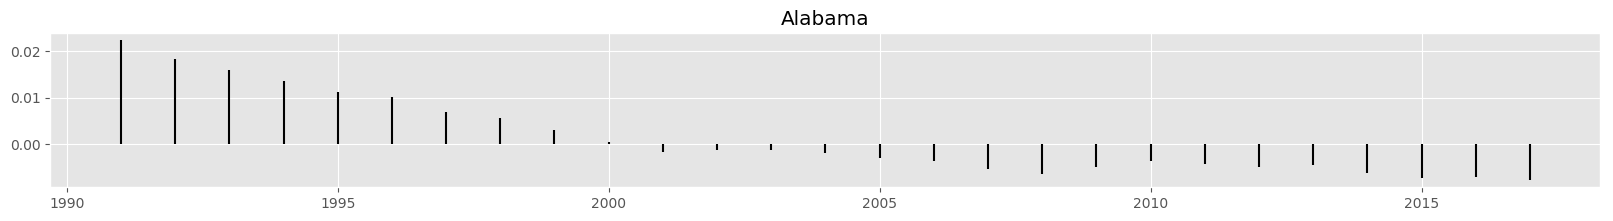

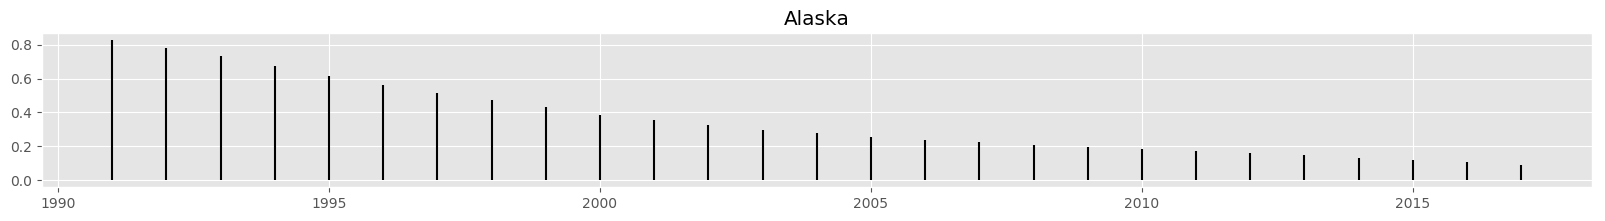

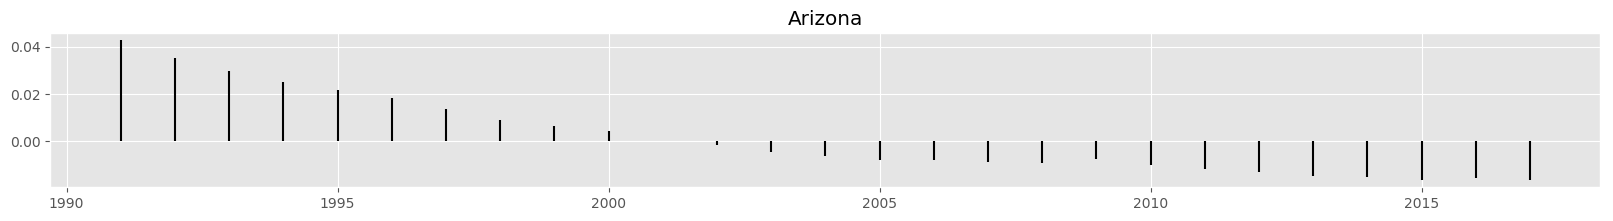

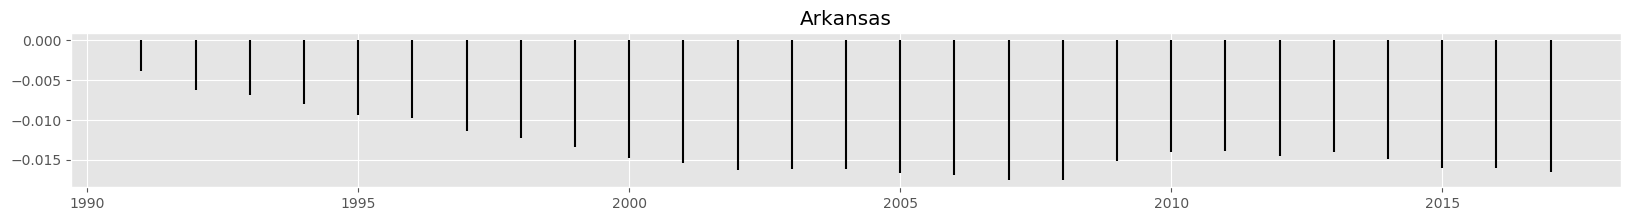

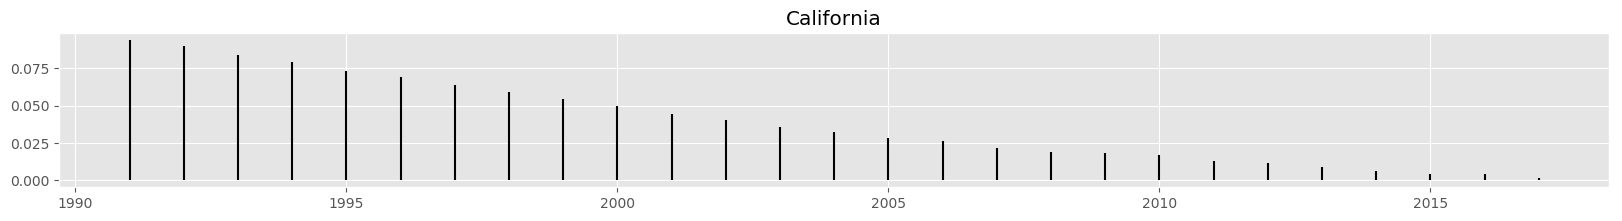

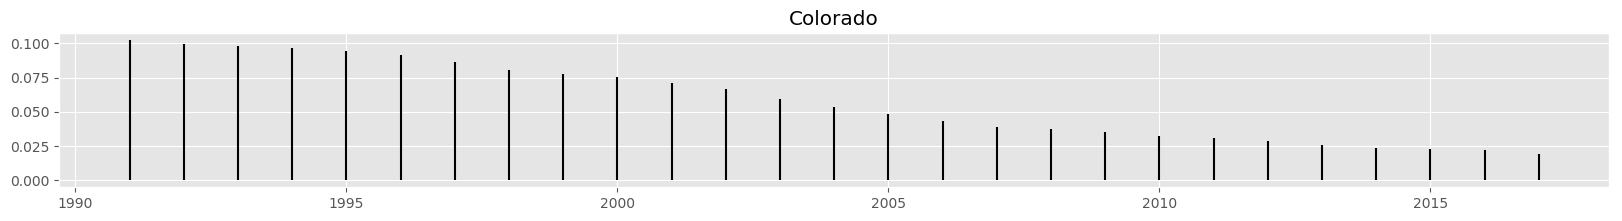

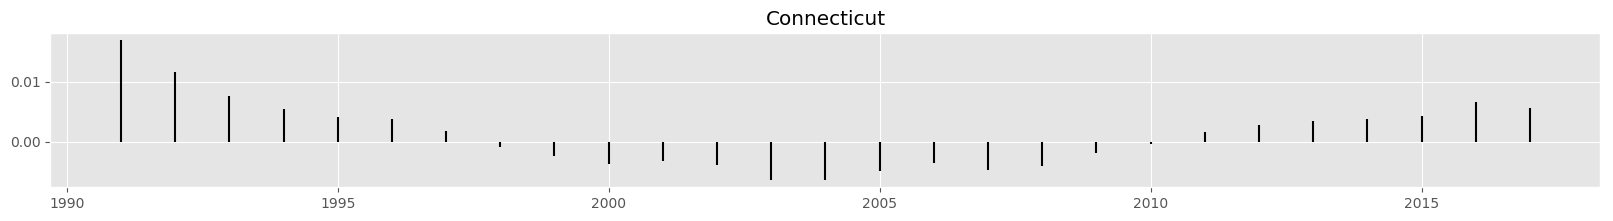

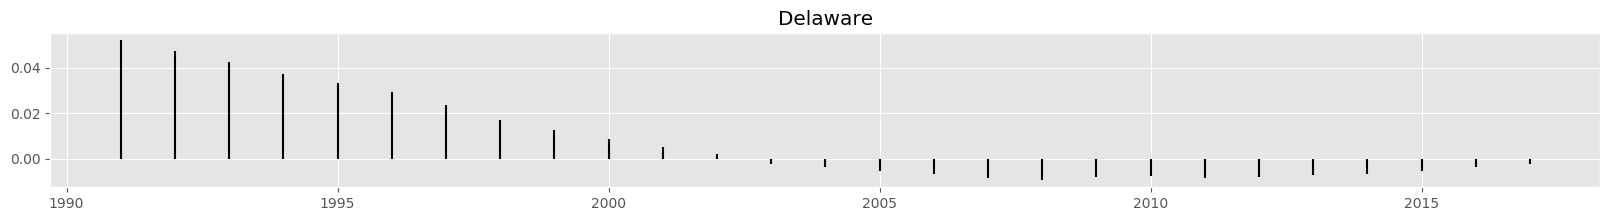

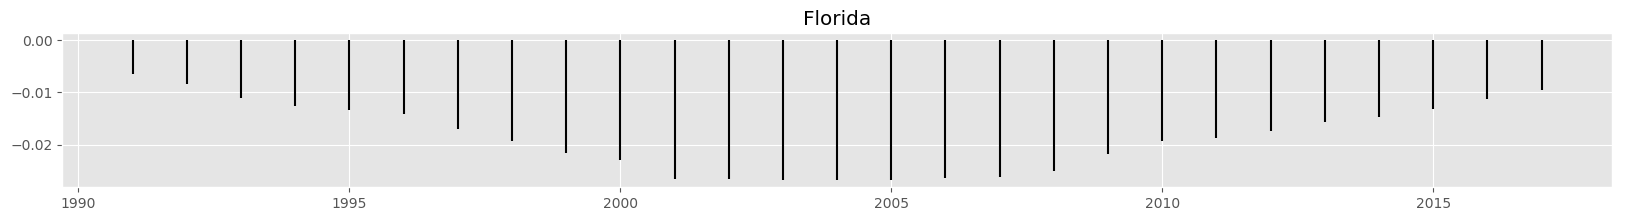

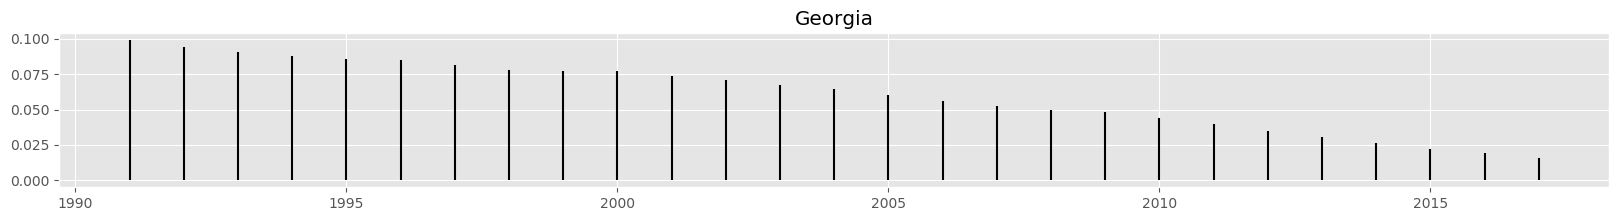

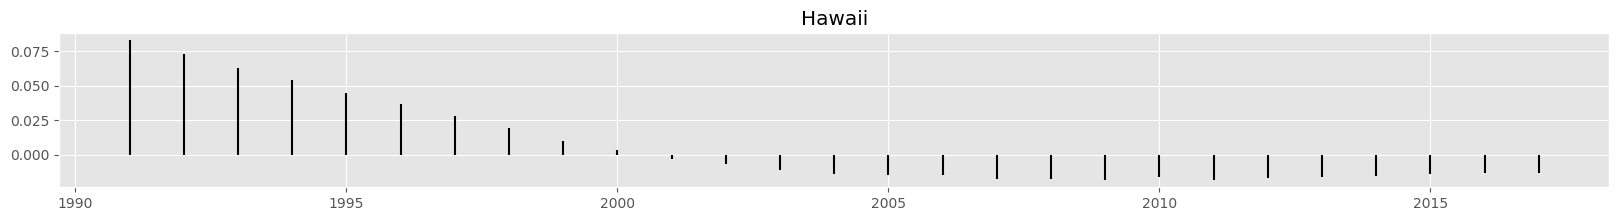

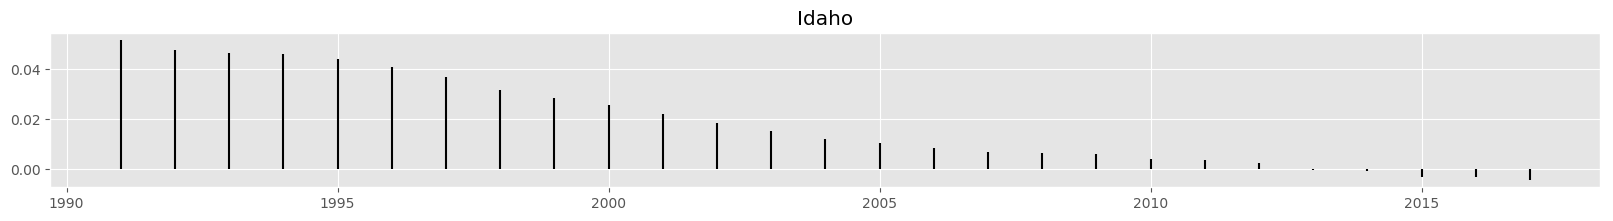

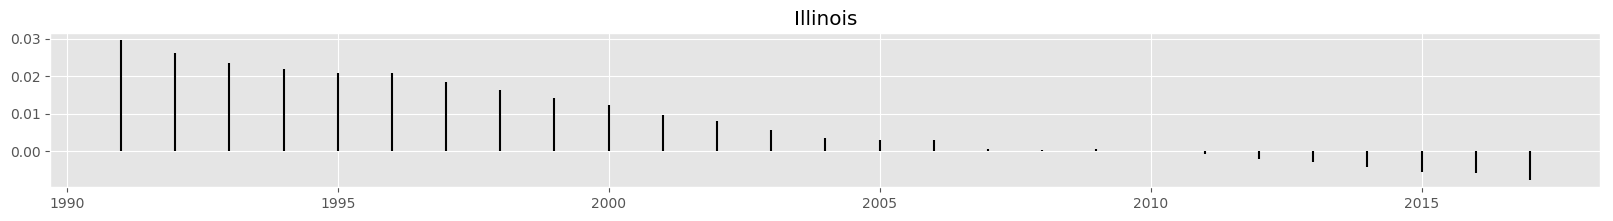

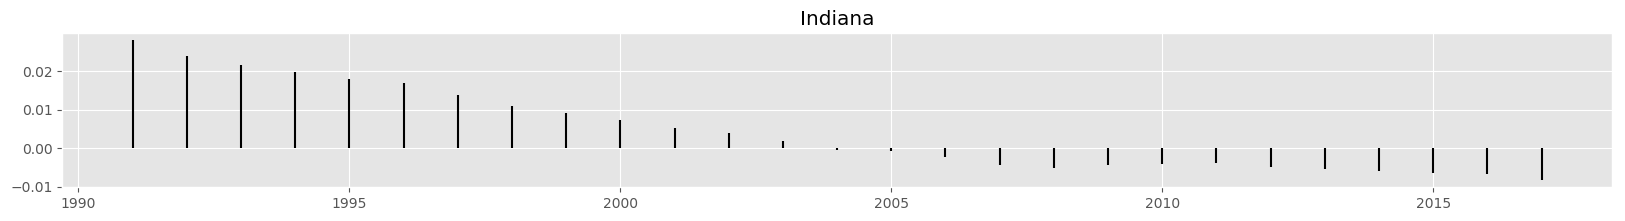

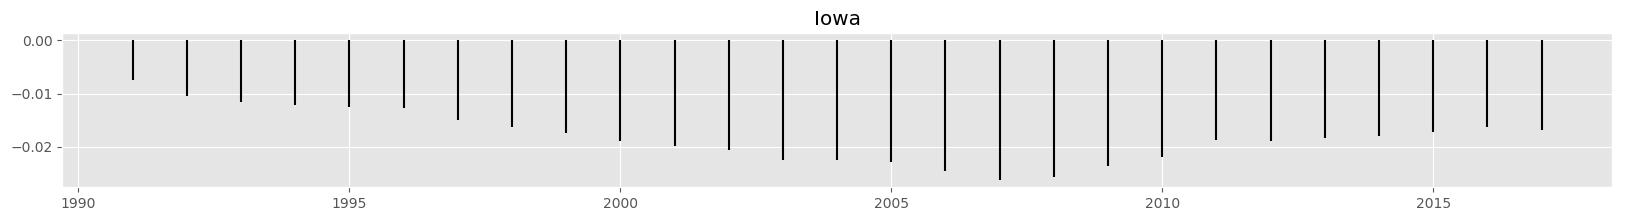

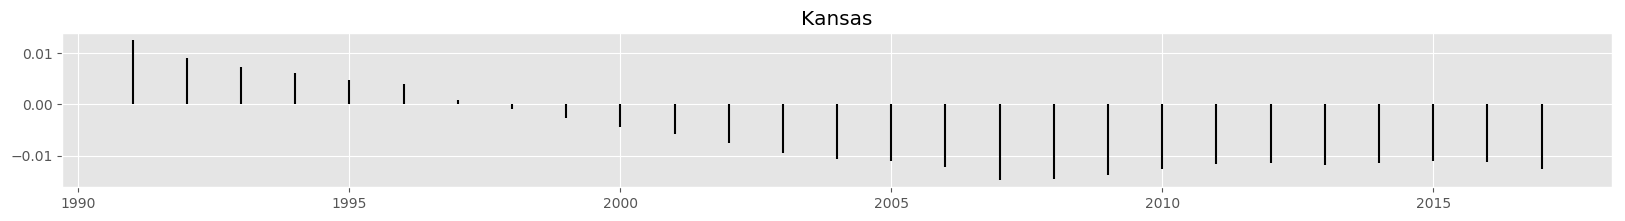

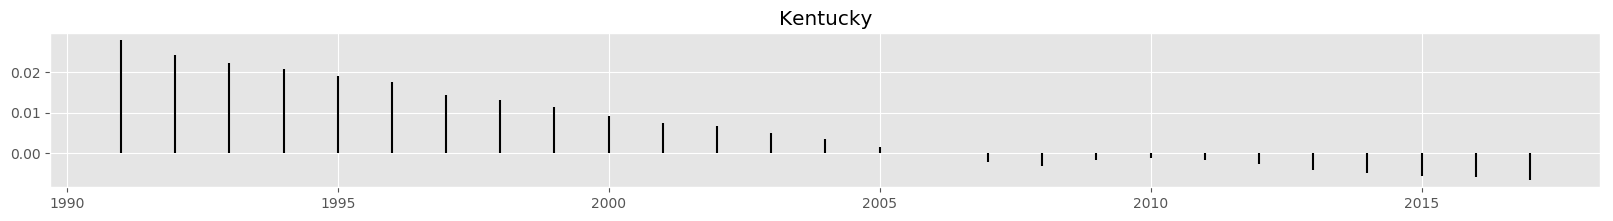

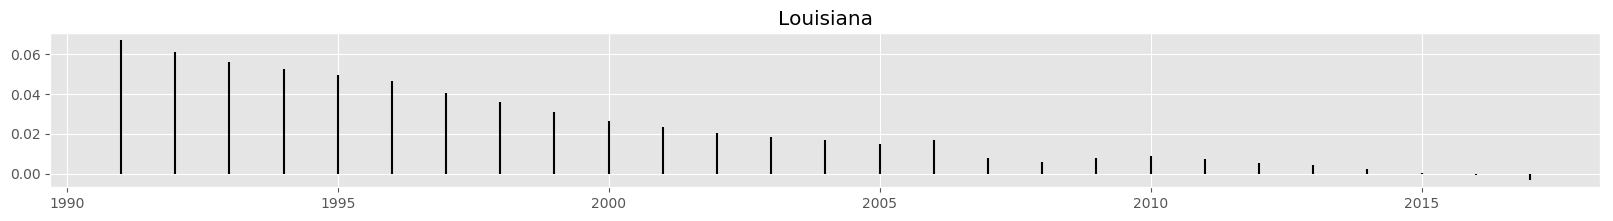

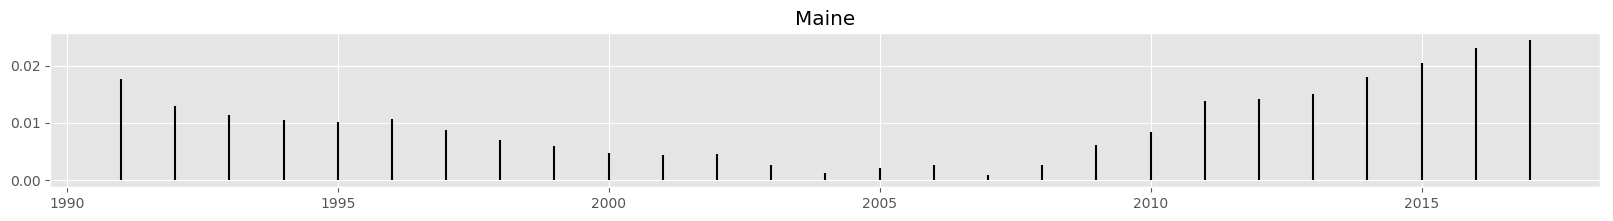

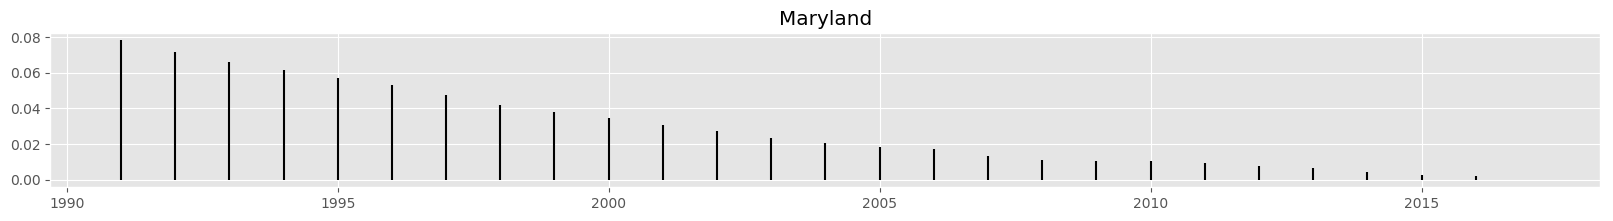

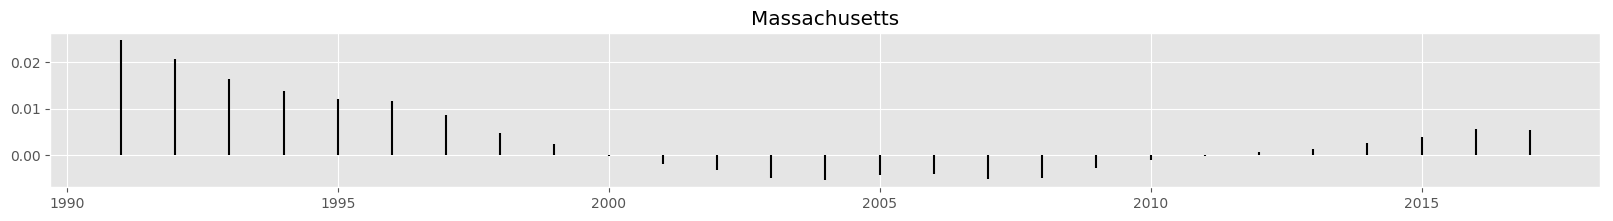

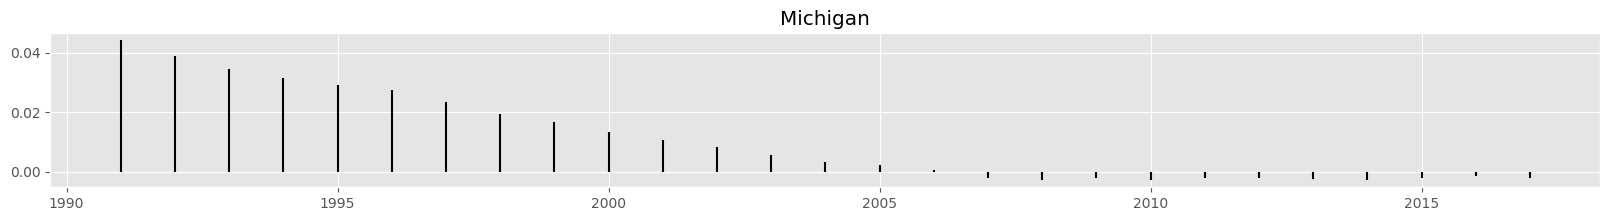

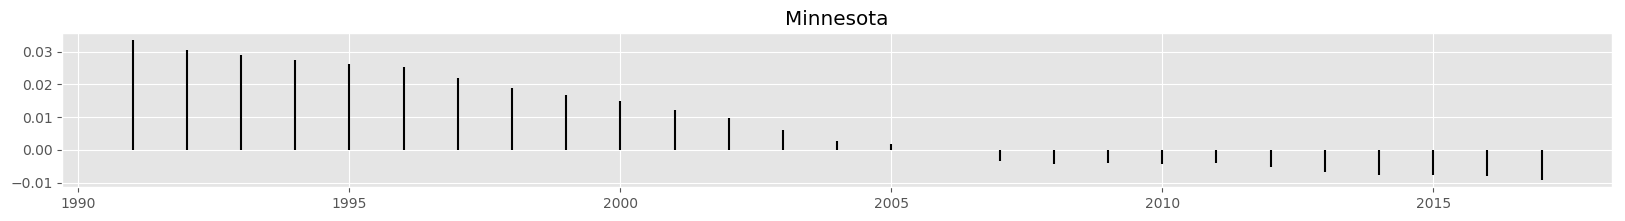

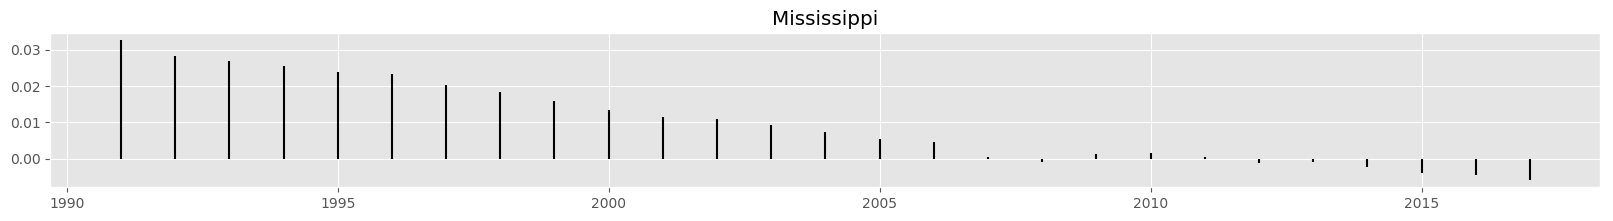

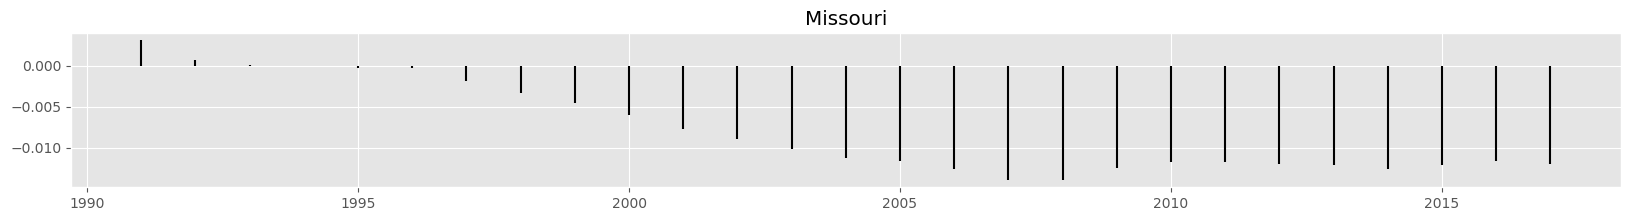

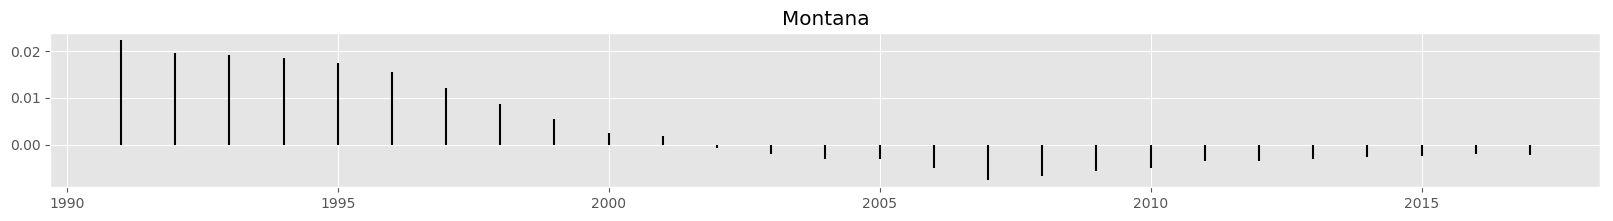

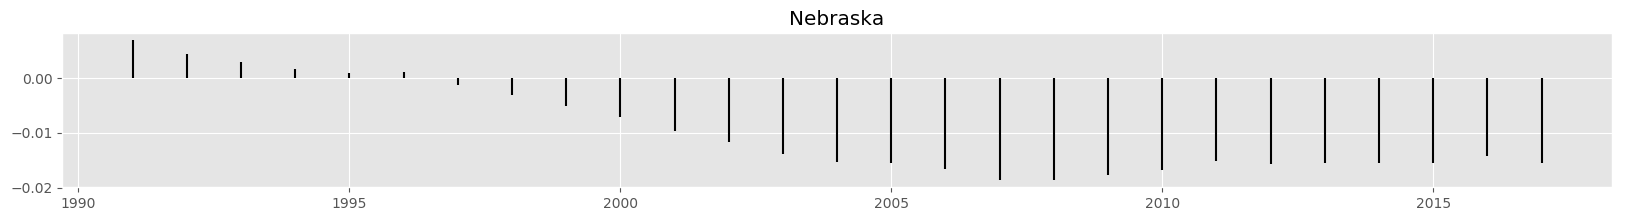

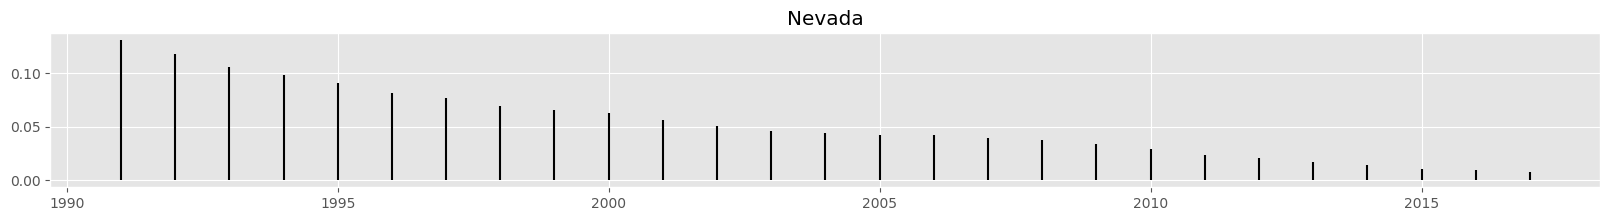

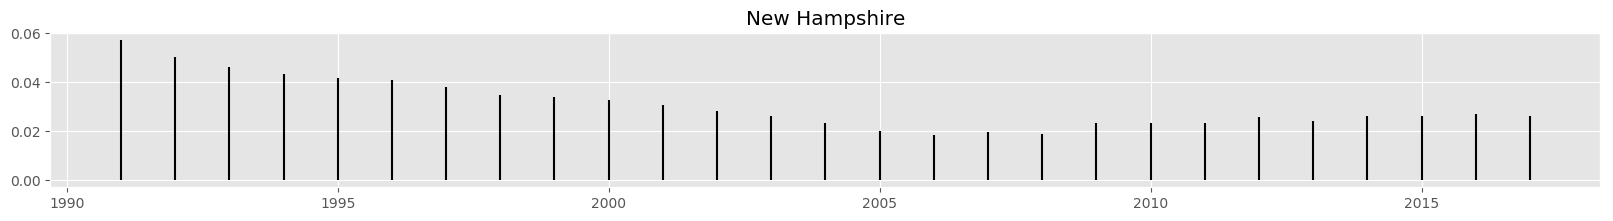

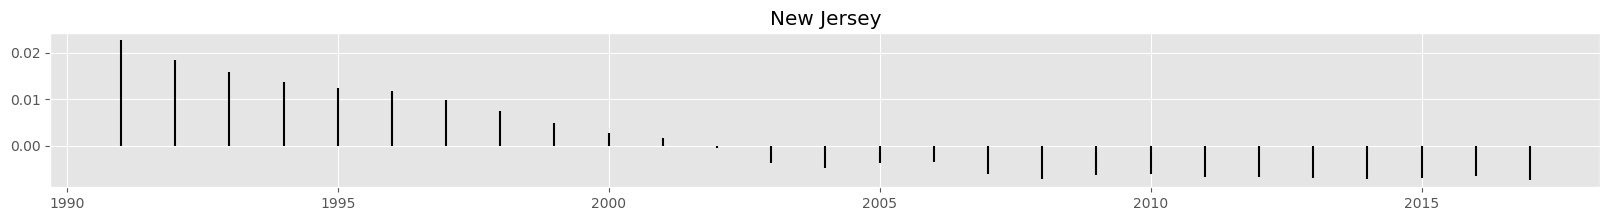

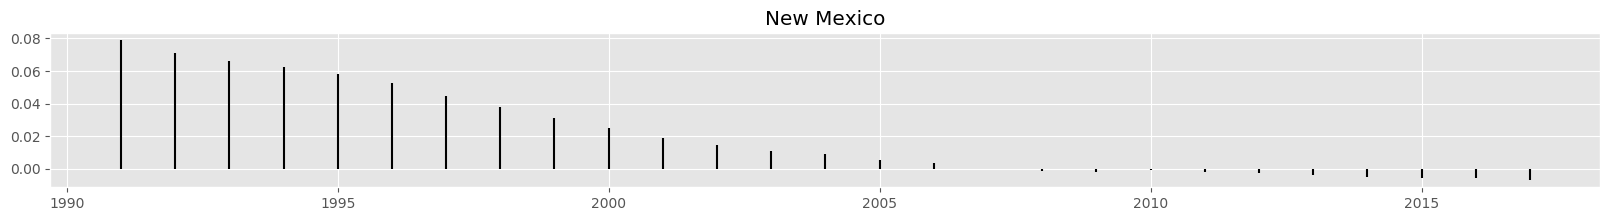

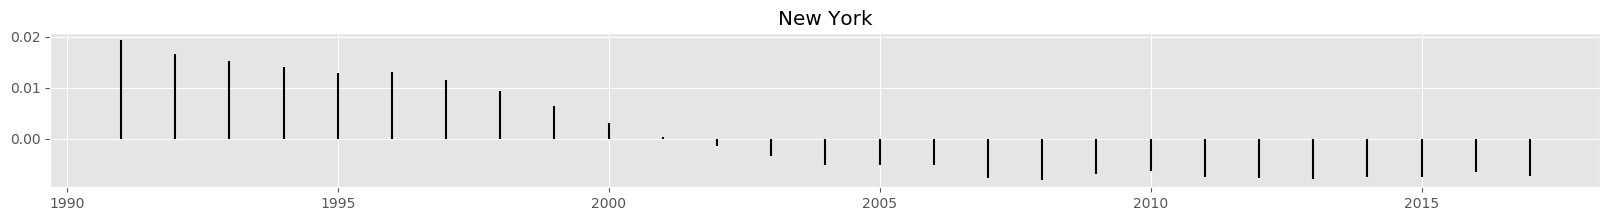

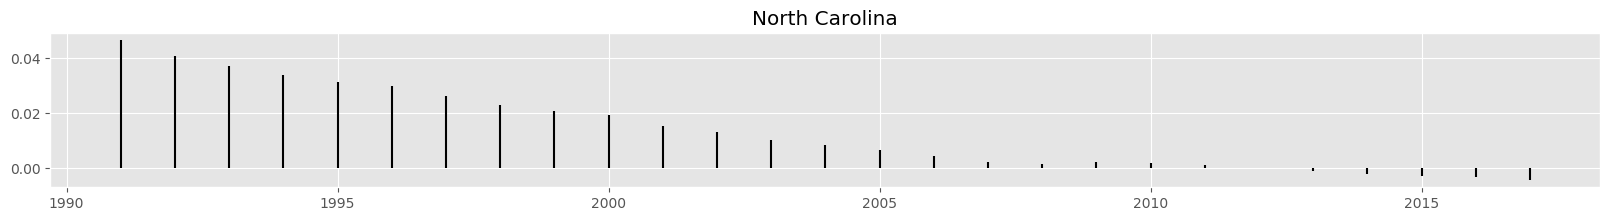

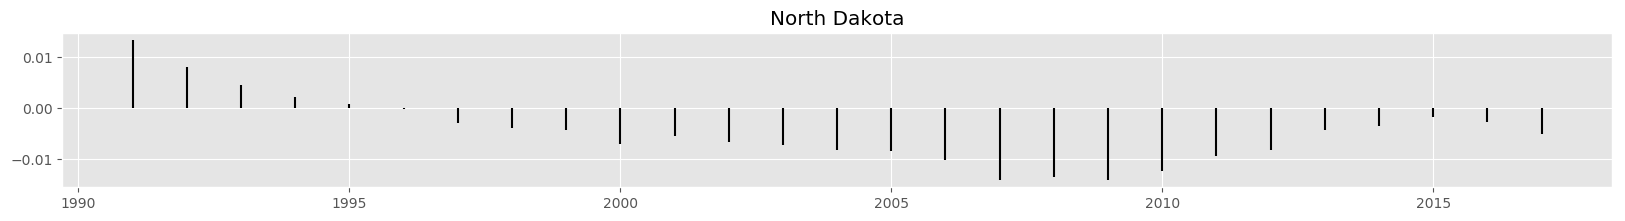

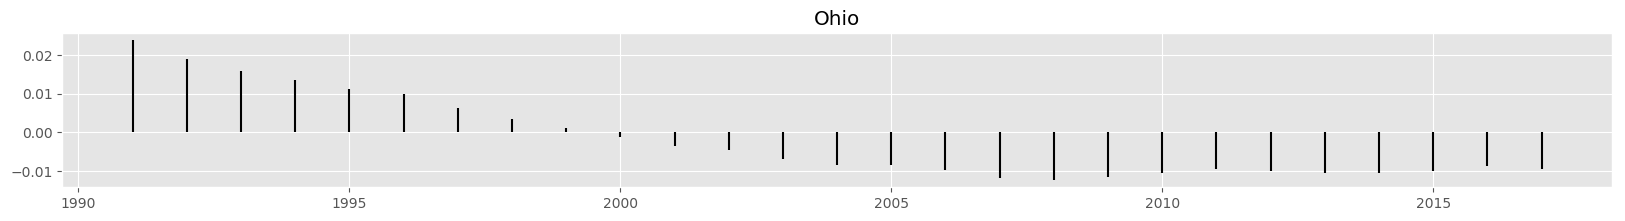

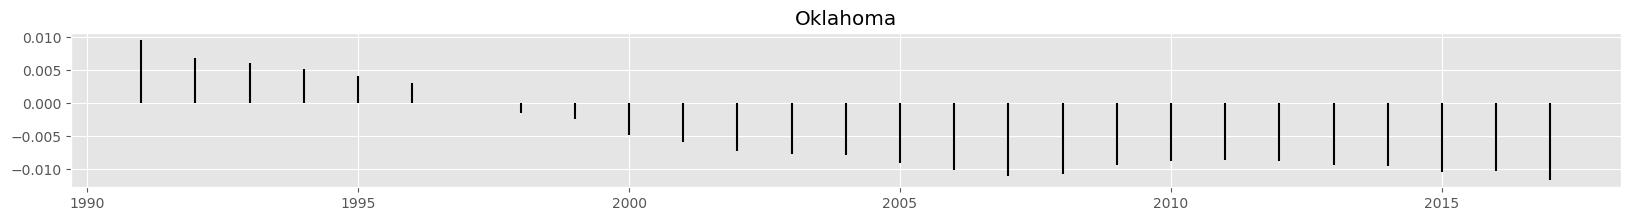

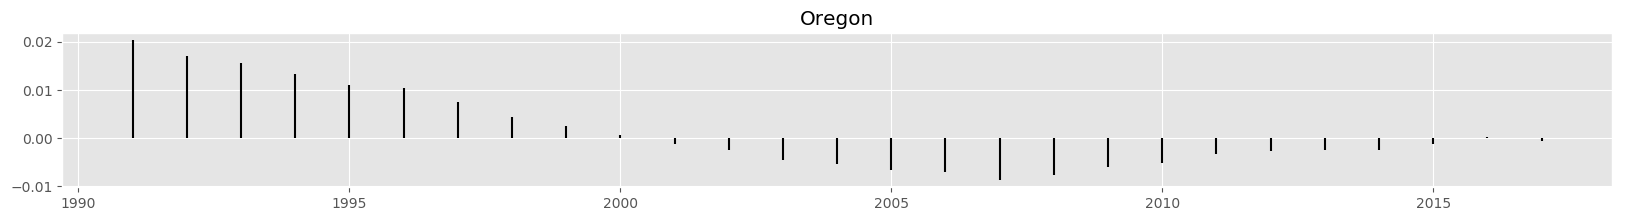

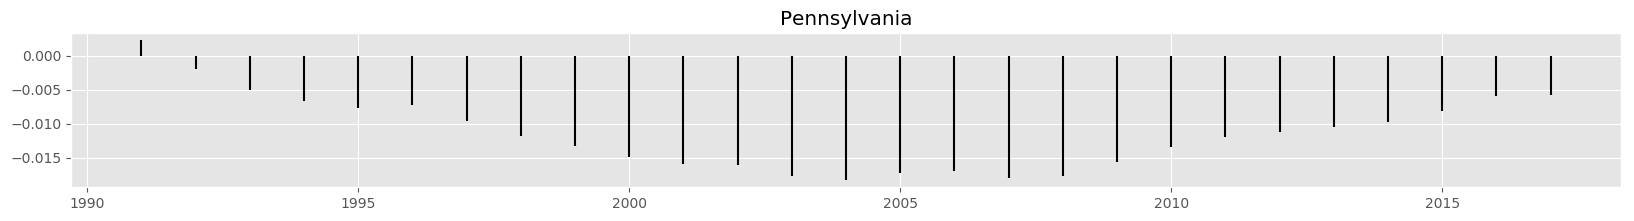

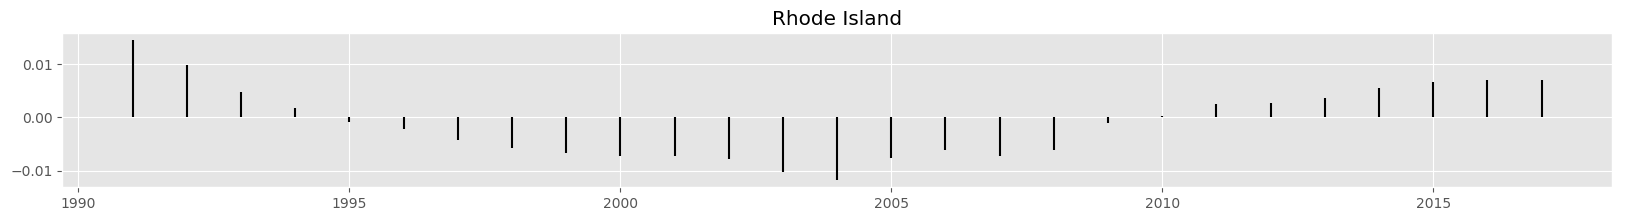

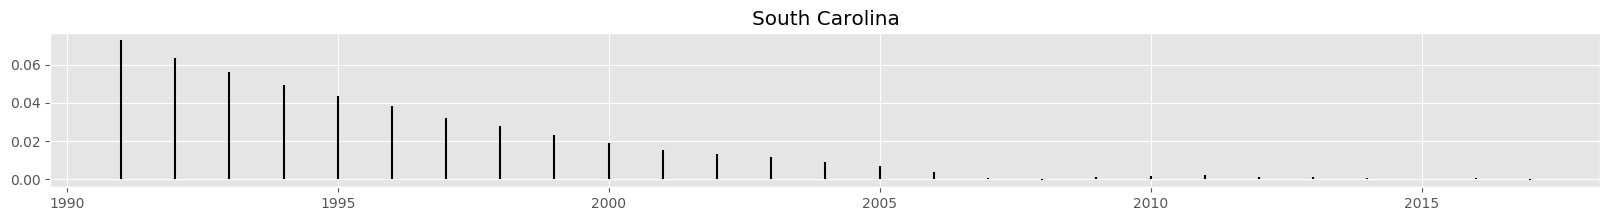

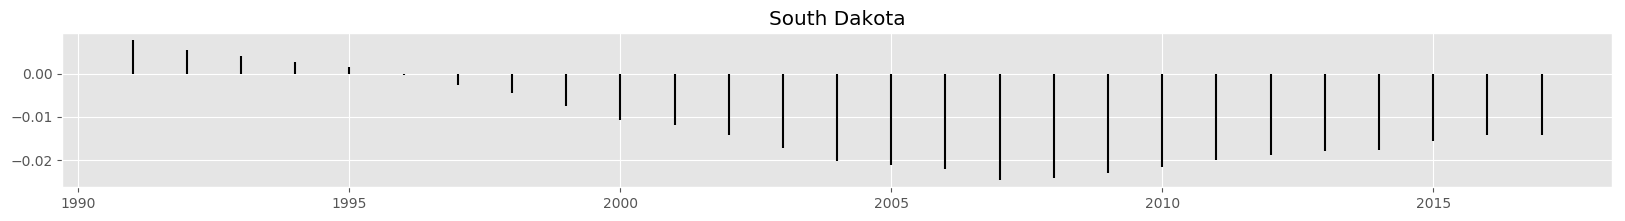

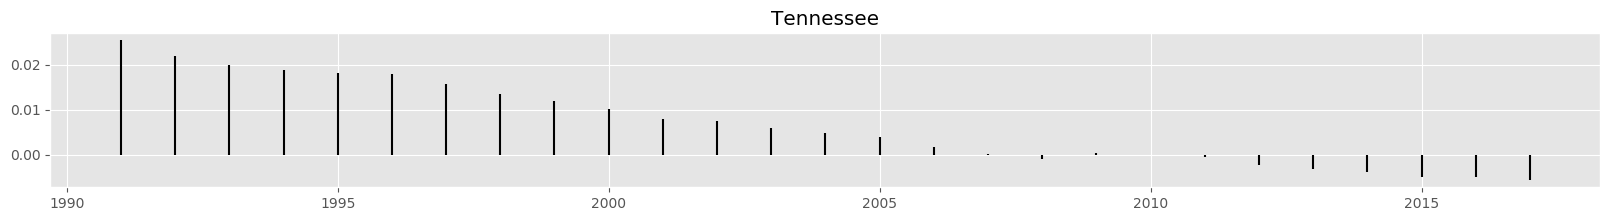

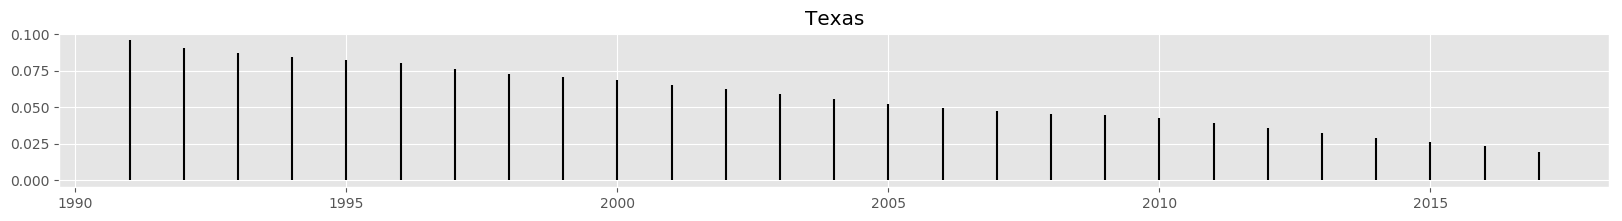

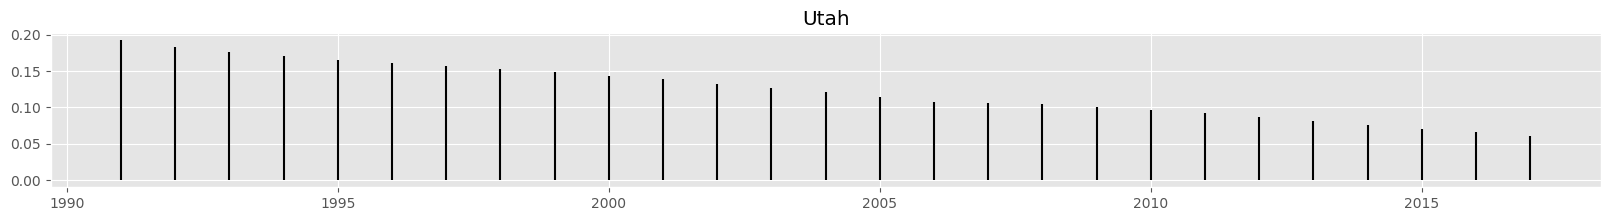

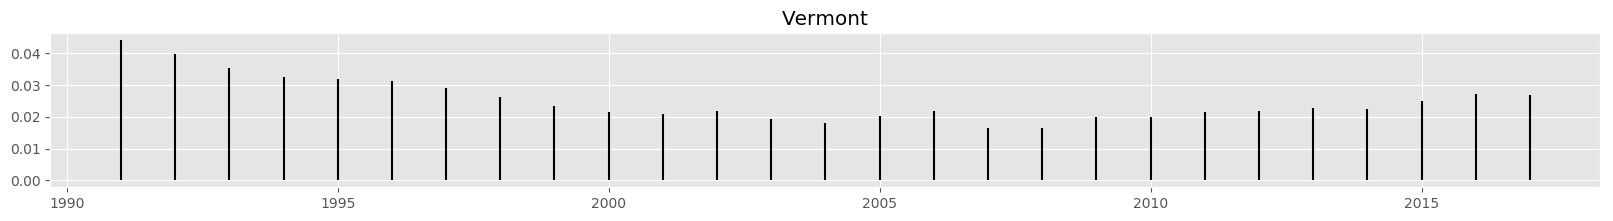

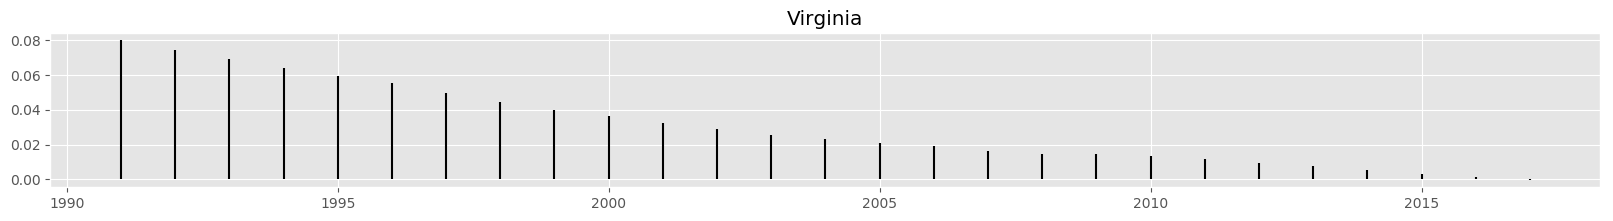

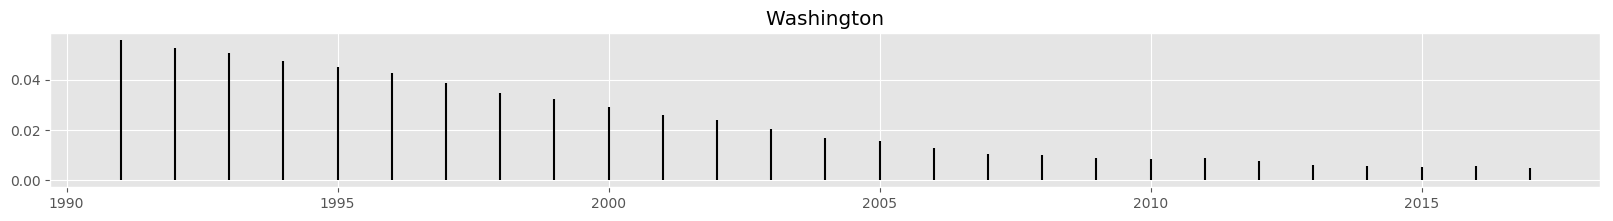

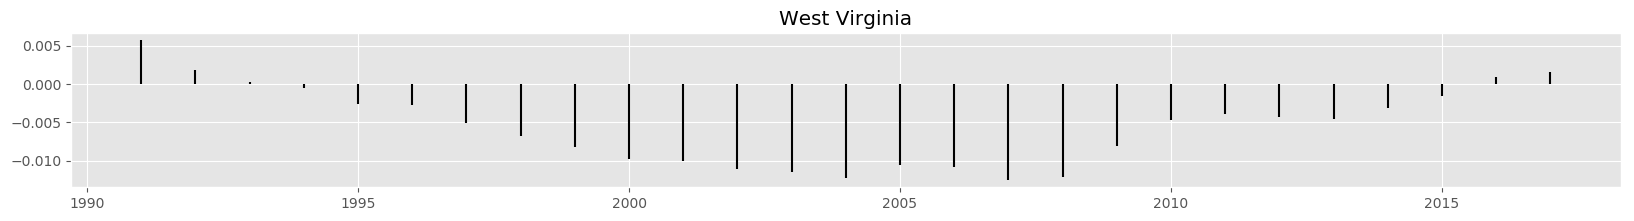

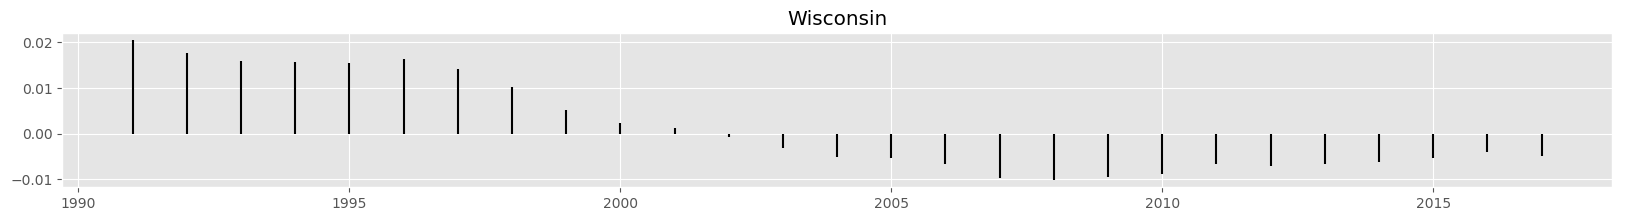

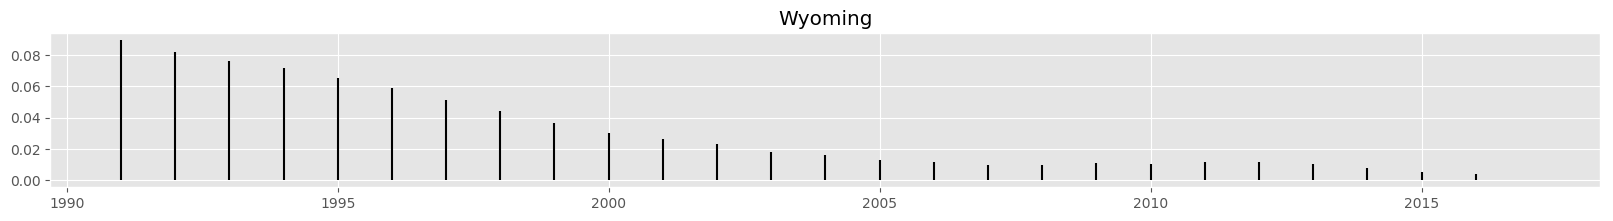

In [40]:
for state in joined_df.State.unique():
    difference_tracking = joined_df[['State', 'Homicide Rate', 'Age Standardized Rate']][joined_df.State==state]
    difference_tracking['Difference'] = difference_tracking['Age Standardized Rate'] / difference_tracking['Homicide Rate'] - 1

    X = [i for i in range(len(difference_tracking.Difference))]
    y = difference_tracking.Difference

    plt.figure(figsize=(20, 2))
    for i in range(len(X)):
        plt.vlines(X[i], 0, y[i])
    plt.xticks([i*5-1 for i in range(6)], [1990 + 5*i for i in range(6)])
    plt.title(state)

plt.show()

In [41]:
# Drop extraneous columns and save to new dataframe
standardized_df = joined_df[['Age Standardized Rate']]
standardized_df.head()

,Age Standardized Rate
State-Year,
Alabama 1991,11.697527
Alabama 1992,11.153367
Alabama 1993,11.669401
Alabama 1994,11.919728
Alabama 1995,11.179830


### Validate Standardization
To show that the standardization applied does not skew the results, Giffords Law Ratings will be mapped, and the same regressions run as before, checking to make sure no significant deviation in results is observed despite the differences in point-in-time rate calculations.

In [42]:
compiled_data['State-Year'] = compiled_data.State + ' ' + compiled_data.Year.astype('str')
compiled_data = compiled_data.set_index('State-Year')
giffords_std_df = compiled_data.join(standardized_df['Age Standardized Rate']).dropna()
giffords_std_df = giffords_std_df.rename(columns={'Age Standardized Rate':'Age_Standardized_Rate'})
giffords_std_df = giffords_std_df[giffords_std_df.Year > 2015]
giffords_std_df.head()

,Year,State,Grade,State_GPA,Gun Death Rate,Homicide Rate,Suicide Rate,Accident Rate,Neighbor_State_GPAs,Age_Standardized_Rate
State-Year,,,,,,,,,,
Alabama 2017,2017,Alabama,F,0.0,22.9,12.9,16.6,53.8,0.600000,12.253039
Alaska 2017,2017,Alaska,F,0.0,24.5,10.6,27.0,53.8,0.000000,11.519575
Arizona 2017,2017,Arizona,F,0.0,15.8,6.6,18.2,63.7,1.540000,6.183709
Arkansas 2017,2017,Arkansas,F,0.0,20.3,9.8,20.8,56.2,0.116667,9.100343
California 2017,2017,California,A,4.0,7.9,5.1,10.5,51.8,1.100000,5.122240


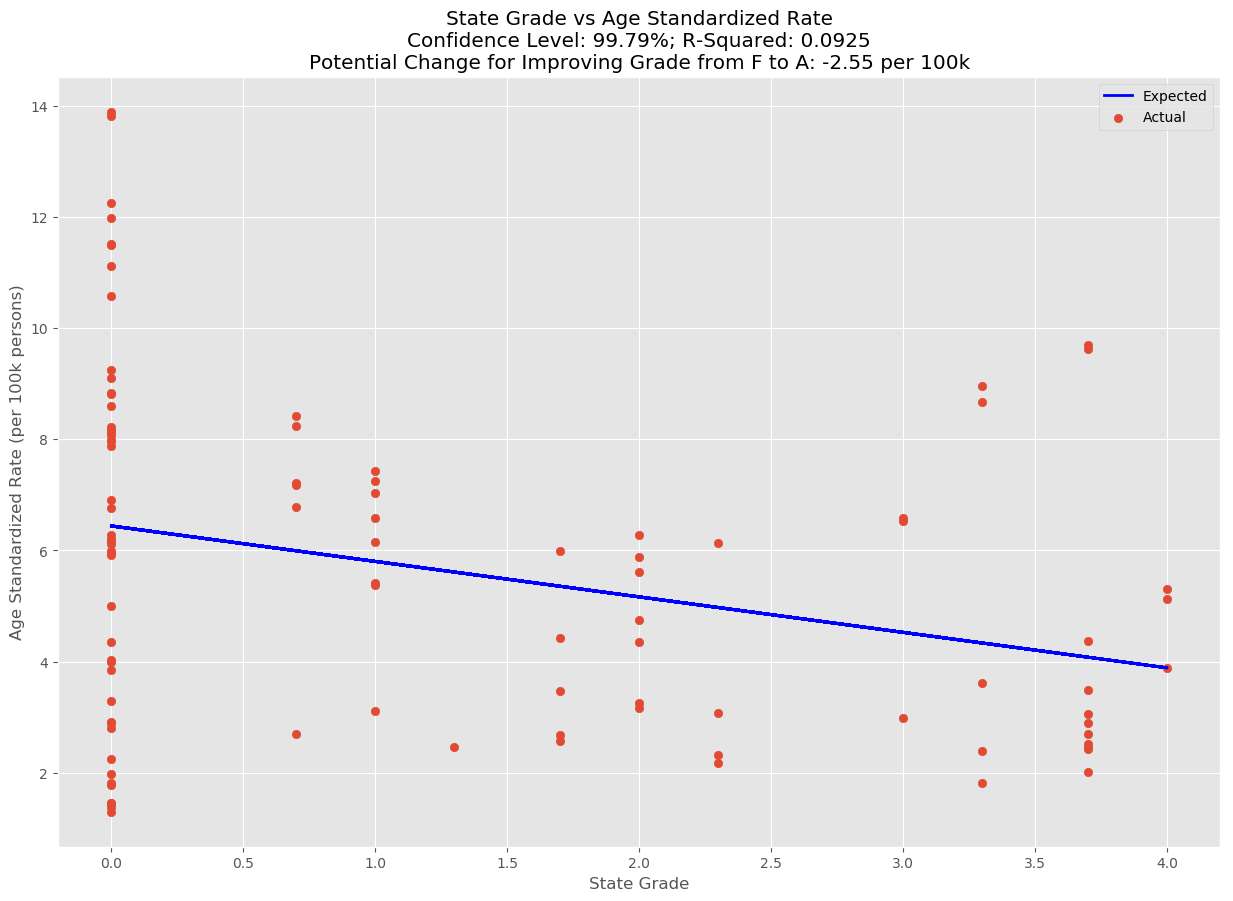

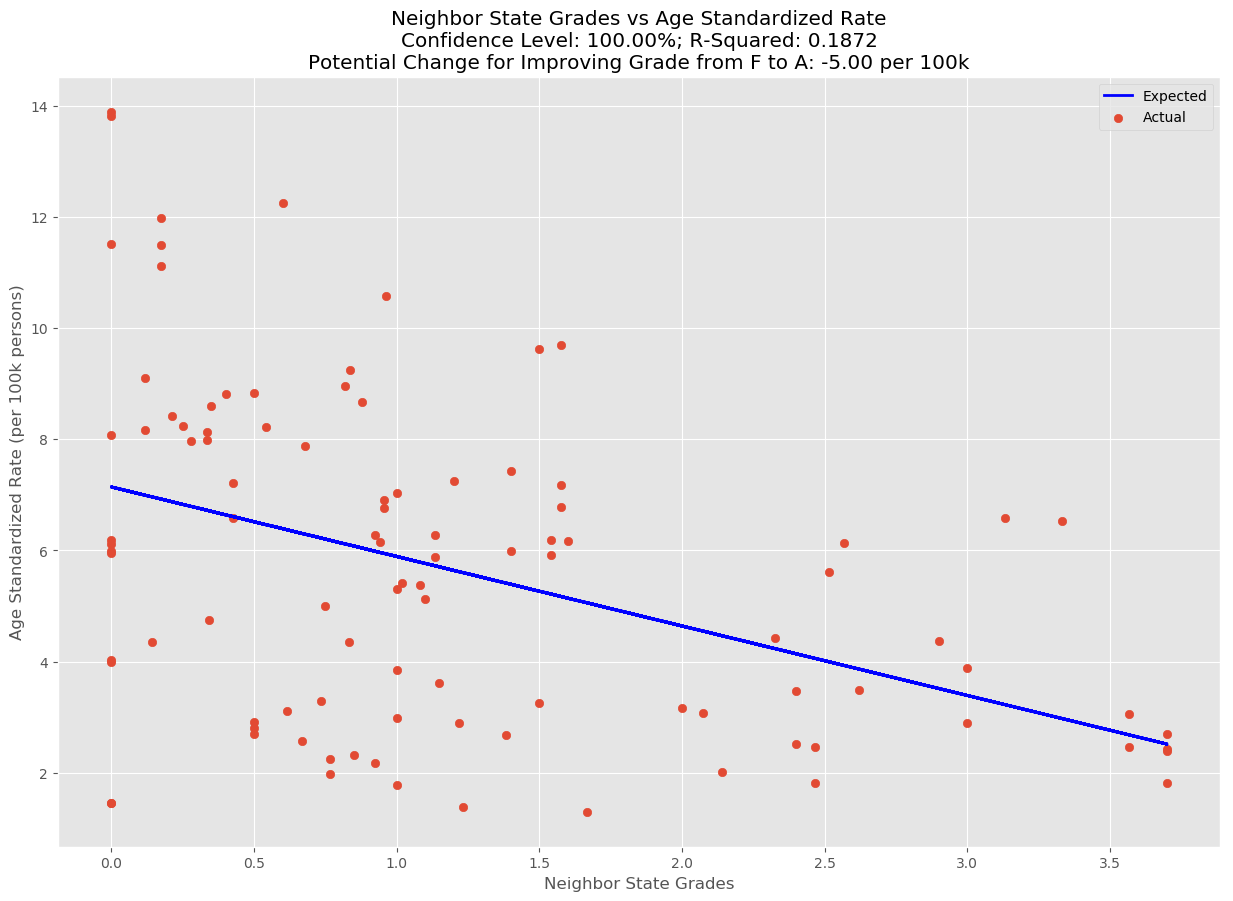

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Age_Standardized_Rate,State_GPA,0.092491,6.440300,-0.638449,0.002096
1,Age_Standardized_Rate,Neighbor_State_GPAs,0.187231,7.141586,-1.250749,0.000007


In [43]:
predictors = ['State_GPA', 'Neighbor_State_GPAs']
targets = [giffords_std_df.columns[-1]]

regression(giffords_std_df, predictors, targets)

10% Complete
20% Complete
30% Complete
40% Complete
50% Complete
60% Complete
70% Complete
80% Complete
90% Complete
100% Complete


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


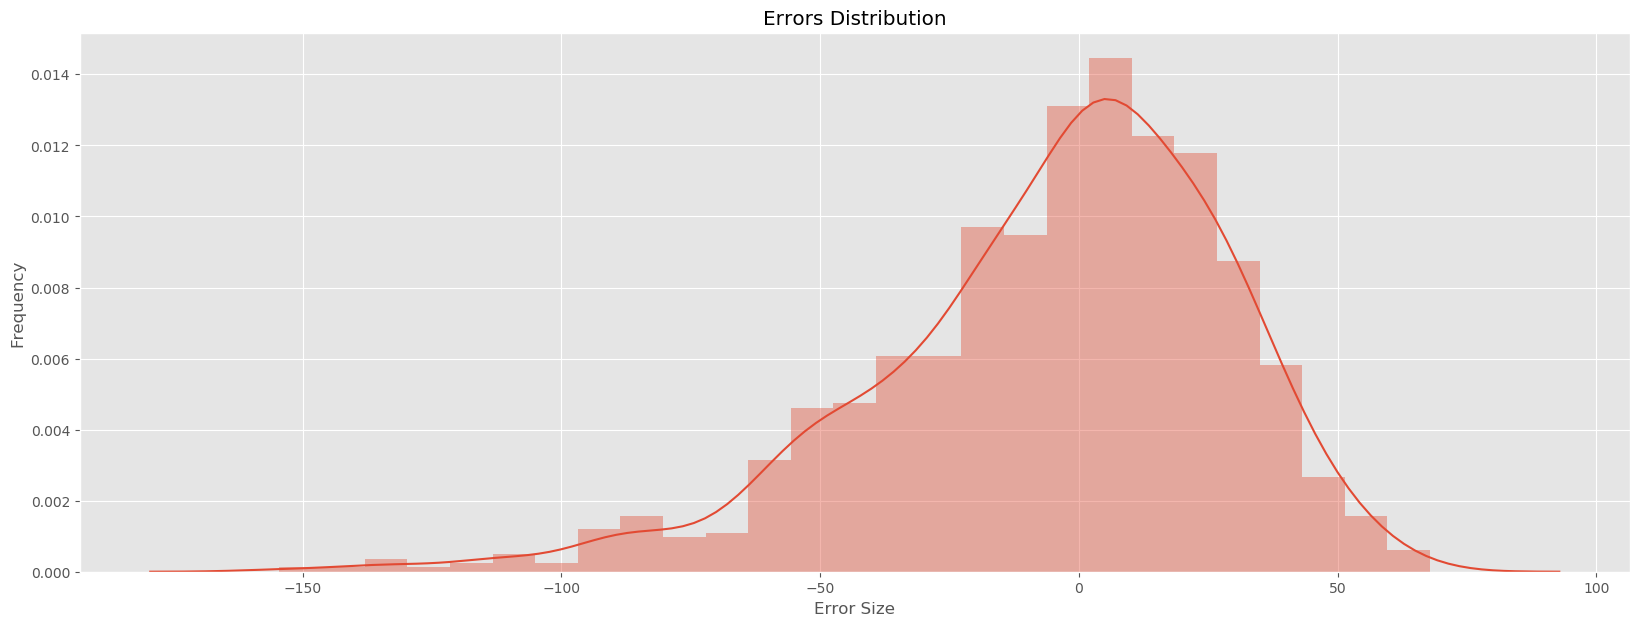

In [44]:
X = giffords_std_df[['State', 'Year', 'Neighbor_State_GPAs']]
y = giffords_std_df['Age_Standardized_Rate']

errors = []
n=1000
for i in range(n):
    pred_df, diff = train_linreg(X, y)
    errors.append(diff)
    
    if (100 * ((i+1) / n)) % 10 == 0:
        print(f'{int(100 * (i+1)/n)}% Complete')
          
plt.figure(figsize=(20, 7))
sns.distplot(errors)
plt.title('Errors Distribution')
plt.xlabel('Error Size')
plt.ylabel('Frequency')
plt.show()

In [45]:
f = 'Age_Standardized_Rate~+State_GPA+Neighbor_State_GPAs'
model = smf.ols(formula=f, data=giffords_std_df).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Age_Standardized_Rate   R-squared:                       0.187
Model:                               OLS   Adj. R-squared:                  0.171
Method:                    Least Squares   F-statistic:                     11.18
Date:                   Tue, 20 Aug 2019   Prob (F-statistic):           4.26e-05
Time:                           03:32:46   Log-Likelihood:                -241.33
No. Observations:                    100   AIC:                             488.7
Df Residuals:                         97   BIC:                             496.5
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

### Observations
While a state's gun law grade appears to have a strong impact on suicide rates, it is the grade of neighboring states that has the biggest impact on a state's homicide rate.

## Append Mass Homicide Data
Even though filters included situations where there were at least 10 injuries, fatality data is the only item of interest. Though other types of attacks may be attempted, differences in survivability are of interest as well.

In [46]:
# Join attack types & fatalities
mass_kill_df = standardized_df.join(mass_shooting_data['Attack Type']).fillna('None')
mass_kill_df = mass_kill_df.join(mass_shooting_data['Fatalities']).fillna(0)

# Get dummies for shooting vs other attacks
mass_kill_df = mass_kill_df.join(pd.get_dummies(mass_kill_df['Attack Type'])).drop(['None', 'Attack Type'], axis=1)
mass_kill_df[mass_kill_df.Fatalities>0]

,Age Standardized Rate,Fatalities,Mass Shooting,Other Attack
State-Year,,,,
Arizona 1995,10.121333,1.0,0,1
California 2014,4.418541,4.0,1,0
California 2015,5.112857,16.0,1,0
Colorado 1999,4.718815,15.0,1,0
Florida 2016,6.193339,50.0,1,0
Georgia 1996,9.112286,1.0,0,1
Minnesota 2016,2.316263,1.0,0,1
Nevada 2017,7.429074,59.0,1,0
New York 1995,8.475375,8.0,1,0


In [47]:
for attack in ['Mass Shooting', 'Other Attack']:
    atck_df = mass_kill_df[mass_kill_df[attack]==1]['Fatalities']
    avg, ct = atck_df.mean(), atck_df.count()
    print(f'Total {attack}s:\t{ct}\nMortality Rate:\t\t{avg:.2f}\n')    

Total Mass Shootings:	12
Mortality Rate:		16.92

Total Other Attacks:	8
Mortality Rate:		3.75



Given the disparity in mortality rates, little weight should be given to suggestions that mass murdurers will use other weapons if guns are not available. Even if the suggestions prove to be true, reductions in life lost can still be significantly realized. If the same rates were maintained and all mass shootings were other forms of attack, 158 lives would have been spared.

## Gun Law Features Over Time
[Everytown Research](https://everytownresearch.org)

In [124]:
q_dict = {}

topic = 'domestic_violence'
i = 1

q = pd.read_csv(f'everytown_questions/{topic}/q{i}.csv')

q_dict[topic] = {}
q_dict[topic][f'q{i}'] = q.question[0]

q = q[q.columns[:5]][(q.state != 'DC') & (q.year <= 2017)]
q['State'] = [state_abbrs[st] for st in q['state']]
q['State-Year'] = q.State + ' ' + q.year.astype('str')
cl_q = q.set_index('State-Year')[['State', 'year']].drop_duplicates()
dumb_cols = pd.get_dummies(q['applies to']).drop('All', axis=1).columns
for col in dumb_cols:
    cl_q[col] = [0 for i in range(1350)]

for i in range(len(q.index)):
    appl = q.iloc[i]['applies to']
    resp = q.iloc[i]['response']
    st = q.iloc[i]['State']
    yr = str(q.iloc[i]['year'])
    ix = f'{st} {yr}'
    if resp == 'No':
        pass
    elif appl == 'All':
        for col in dumb_cols:
            cl_q.loc[[ix], [col]] = 1
    else:
        cl_q.loc[[ix], [appl]] = 1
        
cl_q.drop(['State', 'year'], axis=1)

,Handgun Possession,Handgun possession,Handgun purchase,Long gun possession,Long gun purchase,Possession,Purchase,initial
State-Year,,,,,,,,
Hawaii 1991,0,0,0,0,0,1,1,0
Alaska 1991,0,0,0,0,0,0,0,0
Oregon 1991,0,0,0,0,0,0,0,0
Washington 1991,0,0,0,0,0,0,0,0
California 1991,1,1,1,1,1,1,1,1
Nevada 1991,0,0,0,0,0,0,0,0
Idaho 1991,0,0,0,0,0,0,0,0
Utah 1991,0,0,0,0,0,0,0,0
Arizona 1991,0,0,0,0,0,0,0,0


In [125]:
q

,question,state,year,applies to,response,State,State-Year
0,Does state law prohibit people who have been c...,HI,1991,Possession,Yes,Hawaii,Hawaii 1991
1,Does state law prohibit people who have been c...,HI,1991,Purchase,Yes,Hawaii,Hawaii 1991
2,Does state law prohibit people who have been c...,AK,1991,Handgun possession,No,Alaska,Alaska 1991
3,Does state law prohibit people who have been c...,AK,1991,Long gun possession,No,Alaska,Alaska 1991
4,Does state law prohibit people who have been c...,OR,1991,All,No,Oregon,Oregon 1991
5,Does state law prohibit people who have been c...,WA,1991,All,No,Washington,Washington 1991
6,Does state law prohibit people who have been c...,CA,1991,All,Yes,California,California 1991
7,Does state law prohibit people who have been c...,NV,1991,All,No,Nevada,Nevada 1991
8,Does state law prohibit people who have been c...,ID,1991,All,No,Idaho,Idaho 1991
9,Does state law prohibit people who have been c...,UT,1991,All,No,Utah,Utah 1991
